# Model Monitoring & CI/CD — Hard Drive Failure Prediction

This notebook implements **automated model monitoring and retraining-trigger quality gates** for the LightGBM hard-drive failure prediction model deployed in `base_model.ipynb`.

## Monitoring Strategy

The deployed model is assumed to be **production-ready**. This pipeline treats new production data as **unseen data** and evaluates whether the model's performance has degraded enough to warrant retraining:

1. **Performance degradation check (hard gate):** Recall on the positive (failure) class must remain **≥ 70 %** on new production data. If recall drops below this threshold, **retraining is triggered**.
2. **Metric regression checks (soft gates):** Precision, false positives, ROC-AUC, and average precision are compared against training baselines. Degradation beyond tolerance triggers **retraining warnings** that accumulate toward a retrain signal.
3. **Data drift detection (hard gate):** Feature null rates and distribution drift (z-score) are checked against training baselines. Significant drift indicates the production data distribution has shifted and the model may no longer be valid — **triggering retraining**.

## Decision Logic

- **RETRAIN** if recall drops below 70 % on production data
- **RETRAIN** if significant data drift is detected (missing features or severe distribution shift)
- **RETRAIN WARNING** if ≥ 2 secondary metrics have regressed beyond tolerance
- **HEALTHY** if all gates pass — model is still performing well on production data

## Prerequisites

- `base_model.ipynb` has been run end-to-end, producing:
  - Model artifacts and metadata in S3
  - Monitoring constraints JSON in S3
  - Model quality baseline CSV in S3
  - Data quality baseline JSON in S3
  - `.env` file with all S3 URIs
- The model is deployed and serving production traffic

## 1. Environment Setup

Load AWS session, environment variables, and monitoring constraints from S3.

In [ ]:
import os
import json
import boto3
import numpy as np
import pandas as pd
import sagemaker
from datetime import datetime
from dotenv import load_dotenv

# Load environment variables
ENV_PATH = ".env"
load_dotenv(ENV_PATH)

bucket = os.getenv("BUCKET_NAME")
region = boto3.session.Session().region_name
role = os.getenv("SAGEMAKER_ROLE")

sagemaker_session = sagemaker.Session()
sm_client = boto3.client('sagemaker', region_name=region)
s3_client = boto3.client('s3', region_name=region)

endpoint_name = os.getenv("ENDPOINT_NAME")

# ── Override Parameters ──────────────────────────────────────────────────────
# Set FORCE_RETRAIN = True  to trigger retraining regardless of quality gates
# Set FORCE_SKIP_RETRAIN = True  to skip retraining regardless of quality gates
# Both False = normal quality-gate-driven behaviour
FORCE_RETRAIN      = False
FORCE_SKIP_RETRAIN = False

print(f"Bucket: {bucket}")
print(f"Region: {region}")
print(f"Role:   {role}")
print(f"Endpoint Name: {endpoint_name}")
print(f"FORCE_RETRAIN:      {FORCE_RETRAIN}")
print(f"FORCE_SKIP_RETRAIN: {FORCE_SKIP_RETRAIN}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Bucket: mlops-backblaze-4263963c-us-east-1
Region: us-east-1
Role:   arn:aws:iam::173448391640:role/LabRole
Endpoint Name: lgb-hdd-failure-endpoint-20260215-185627
FORCE_RETRAIN:      False
FORCE_SKIP_RETRAIN: True


## 2. Load Monitoring Constraints & Baselines

Retrieve the monitoring constraints JSON and baseline artifacts produced by `base_model.ipynb`. These define the quality gates for CI/CD.

In [2]:
# ── Load monitoring constraints from S3 ──────────────────────────────────────
constraints_s3_uri = os.getenv("MONITORING_CONSTRAINTS_S3")
baseline_model_quality_s3 = os.getenv("BASELINE_MODEL_QUALITY_S3")
baseline_data_quality_s3 = os.getenv("BASELINE_DATA_QUALITY_S3")
baseline_training_csv_s3 = os.getenv("BASELINE_TRAINING_CSV_S3")
baseline_prefix_s3 = os.getenv("BASELINE_PREFIX_S3")

print("="*80)
print("LOADING MONITORING CONFIGURATION")
print("="*80)
print(f"  Constraints:     {constraints_s3_uri}")
print(f"  Model Quality:   {baseline_model_quality_s3}")
print(f"  Data Quality:    {baseline_data_quality_s3}")
print(f"  Training CSV:    {baseline_training_csv_s3}")

# Parse S3 URI and download constraints
def s3_uri_to_parts(uri):
    """Split s3://bucket/key into (bucket, key)."""
    path = uri.replace("s3://", "")
    b = path.split("/")[0]
    k = "/".join(path.split("/")[1:])
    return b, k

b, k = s3_uri_to_parts(constraints_s3_uri)
resp = s3_client.get_object(Bucket=b, Key=k)
constraints = json.loads(resp['Body'].read().decode('utf-8'))

print(f"\n{'='*80}")
print("MONITORING CONSTRAINTS LOADED")
print(f"{'='*80}")

# Primary constraint
pc = constraints["primary_constraint"]
print(f"\n  PRIMARY CONSTRAINT (hard gate):")
print(f"    {pc['metric']} {pc['operator']} {pc['threshold']}")
print(f"    Action on violation: {pc['action']}")

# Secondary constraints
print(f"\n  SECONDARY CONSTRAINTS (soft gates):")
for name, cfg in constraints["secondary_constraints"].items():
    if "min" in cfg:
        print(f"    {name:22s} >= {cfg['min']:.4f}  (baseline: {cfg['baseline']:.4f}, action: {cfg['action']})")
    elif "max" in cfg:
        print(f"    {name:22s} <= {cfg['max']}  (baseline: {cfg['baseline']}, action: {cfg['action']})")

# Data quality
dq = constraints["data_quality"]
print(f"\n  DATA QUALITY GATES:")
print(f"    max null %:       {dq['max_null_pct']}")
print(f"    max KS drift:     {dq['max_feature_drift']}")

# Decision threshold & features
decision_threshold = constraints["decision_threshold"]
target_recall = constraints["target_recall"]
feature_cols = constraints["feature_cols"]
print(f"\n  Decision threshold: {decision_threshold:.6f}")
print(f"  Target recall:      {target_recall}")
print(f"  Features:           {feature_cols}")
print(f"{'='*80}")

LOADING MONITORING CONFIGURATION
  Constraints:     s3://mlops-backblaze-4263963c-us-east-1/models/lgb-hdd-failure/20260215-185627/baselines/monitoring_constraints.json
  Model Quality:   s3://mlops-backblaze-4263963c-us-east-1/models/lgb-hdd-failure/20260215-185627/baselines/model_quality_baseline.csv
  Data Quality:    s3://mlops-backblaze-4263963c-us-east-1/models/lgb-hdd-failure/20260215-185627/baselines/data_quality_baseline.json
  Training CSV:    s3://mlops-backblaze-4263963c-us-east-1/models/lgb-hdd-failure/20260215-185627/baselines/training_data_baseline.csv

MONITORING CONSTRAINTS LOADED

  PRIMARY CONSTRAINT (hard gate):
    recall >= 0.7
    Action on violation: reject

  SECONDARY CONSTRAINTS (soft gates):
    precision              >= 0.0006  (baseline: 0.0008, action: warn)
    false_positives        <= 14073  (baseline: 11259, action: warn)
    roc_auc                >= 0.8888  (baseline: 0.9356, action: warn)
    average_precision      >= 0.0117  (baseline: 0.0130, act

## 3. Retraining Quality Gate Functions

Define reusable functions that evaluate the deployed model's predictions on new production data against training baselines. These functions detect performance degradation and data drift to determine if retraining is needed.

In [3]:
from sklearn.metrics import (
    recall_score, precision_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    classification_report
)


def evaluate_recall_gate(y_true, y_pred, target_recall=0.70):
    """
    PRIMARY GATE: Check whether recall on the positive class has degraded
    below the minimum acceptable threshold on production data.
    
    If recall drops below target, the model is no longer catching enough
    failures and retraining is required.
    
    Returns:
        dict with 'passed' (bool), 'recall' (float), 'target' (float), 'action' (str)
    """
    rec = recall_score(y_true, y_pred, zero_division=0)
    passed = rec >= target_recall
    return {
        "gate":    "PRIMARY — Recall Degradation",
        "passed":  passed,
        "value":   round(rec, 6),
        "target":  target_recall,
        "action":  "retrain" if not passed else "healthy",
        "message": f"Recall {rec:.4f} {'≥' if passed else '<'} {target_recall:.2f} on production data",
    }


def evaluate_secondary_gates(y_true, y_pred, y_prob, constraints):
    """
    SECONDARY GATES: Detect regression in precision, FP count, ROC-AUC,
    and Average Precision relative to training baselines.
    
    Each metric is compared against its baseline-derived minimum. Violations
    indicate the model is degrading on production data.
    
    Returns:
        list of dicts, each with 'passed', 'value', 'threshold', 'action'
    """
    sc = constraints["secondary_constraints"]
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    results = []
    
    # Precision
    prec = precision_score(y_true, y_pred, zero_division=0)
    prec_min = sc["precision"]["min"]
    prec_baseline = sc["precision"]["baseline"]
    results.append({
        "gate":    "Precision",
        "passed":  prec >= prec_min,
        "value":   round(prec, 6),
        "target":  round(prec_min, 6),
        "baseline": round(prec_baseline, 6),
        "degradation": round(prec_baseline - prec, 6) if prec < prec_baseline else 0.0,
        "action":  "retrain-warn" if prec < prec_min else "healthy",
    })
    
    # False positives
    fp_max = sc["false_positives"]["max"]
    fp_baseline = sc["false_positives"]["baseline"]
    results.append({
        "gate":    "False Positives",
        "passed":  int(fp) <= fp_max,
        "value":   int(fp),
        "target":  f"<= {fp_max}",
        "baseline": fp_baseline,
        "degradation": int(fp) - fp_baseline if int(fp) > fp_baseline else 0,
        "action":  "retrain-warn" if int(fp) > fp_max else "healthy",
    })
    
    # ROC-AUC
    try:
        auc = roc_auc_score(y_true, y_prob)
    except ValueError:
        auc = float('nan')
    auc_min = sc["roc_auc"]["min"]
    auc_baseline = sc["roc_auc"]["baseline"]
    results.append({
        "gate":    "ROC-AUC",
        "passed":  auc >= auc_min,
        "value":   round(auc, 6),
        "target":  round(auc_min, 6),
        "baseline": round(auc_baseline, 6),
        "degradation": round(auc_baseline - auc, 6) if auc < auc_baseline else 0.0,
        "action":  "retrain-warn" if auc < auc_min else "healthy",
    })
    
    # Average Precision
    try:
        ap = average_precision_score(y_true, y_prob)
    except ValueError:
        ap = float('nan')
    ap_min = sc["average_precision"]["min"]
    ap_baseline = sc["average_precision"]["baseline"]
    results.append({
        "gate":    "Average Precision",
        "passed":  ap >= ap_min,
        "value":   round(ap, 6),
        "target":  round(ap_min, 6),
        "baseline": round(ap_baseline, 6),
        "degradation": round(ap_baseline - ap, 6) if ap < ap_baseline else 0.0,
        "action":  "retrain-warn" if ap < ap_min else "healthy",
    })
    
    return results


def evaluate_data_quality(df_new, baseline_stats, constraints):
    """
    DATA QUALITY / DRIFT GATES: Check null rates and feature distribution drift.
    
    Significant drift indicates the production data distribution has shifted
    from training data, meaning the model may no longer be valid even if
    current metrics still look acceptable.
    
    Args:
        df_new: DataFrame of new production feature data
        baseline_stats: dict of per-feature statistics from training
        constraints: monitoring constraints dict
    
    Returns:
        list of dicts with gate results
    """
    from scipy.stats import ks_2samp
    
    dq = constraints["data_quality"]
    max_null = dq["max_null_pct"]
    max_drift = dq["max_feature_drift"]
    
    results = []
    
    for col in constraints["feature_cols"]:
        if col not in df_new.columns:
            results.append({
                "gate": f"Missing Feature: {col}",
                "passed": False,
                "action": "retrain",
                "message": f"Feature '{col}' not found in production data — schema drift detected",
            })
            continue
        
        # Null rate check
        null_pct = df_new[col].isna().mean() * 100
        null_ok = null_pct <= max_null
        results.append({
            "gate":   f"Null Rate: {col}",
            "passed": null_ok,
            "value":  round(null_pct, 2),
            "target": f"<= {max_null}%",
            "action": "retrain-warn" if not null_ok else "healthy",
        })
        
        # Distribution drift (approximate KS using baseline stats)
        # Flag if the new mean deviates beyond baseline mean ± max_drift * baseline std
        if col in baseline_stats:
            bl = baseline_stats[col]
            new_mean = float(df_new[col].dropna().mean())
            drift = abs(new_mean - bl["mean"]) / bl["std"] if bl["std"] > 0 else 0.0
            drift_ok = drift <= (max_drift * 10)  # normalised z-score threshold
            results.append({
                "gate":   f"Drift: {col}",
                "passed": drift_ok,
                "value":  round(drift, 4),
                "target": f"z-score <= {max_drift * 10:.1f}",
                "action": "retrain" if not drift_ok else "healthy",
            })
    
    return results


def run_all_gates(y_true, y_pred, y_prob, df_features, constraints, baseline_stats):
    """
    Run the full retraining-trigger pipeline on production data.
    
    Decision logic:
      - RETRAIN if recall drops below target (hard gate)
      - RETRAIN if significant data drift is detected
      - RETRAIN WARNING if ≥ 2 secondary metrics have regressed
      - HEALTHY if all gates pass
    
    Returns:
        dict with 'retrain_needed' (bool), 'retrain_reason', 'primary',
        'secondary', 'data_quality' results
    """
    target_recall = constraints["primary_constraint"]["threshold"]
    
    # 1. Primary gate — recall degradation
    primary = evaluate_recall_gate(y_true, y_pred, target_recall)
    
    # 2. Secondary gates — metric regression
    secondary = evaluate_secondary_gates(y_true, y_pred, y_prob, constraints)
    
    # 3. Data quality / drift gates
    data_quality = evaluate_data_quality(df_features, baseline_stats, constraints)
    
    # ── Retraining decision logic ────────────────────────────────────────────
    retrain_reasons = []
    
    # Hard gate: recall degradation
    if not primary["passed"]:
        retrain_reasons.append(
            f"Recall degraded to {primary['value']:.4f} (below {target_recall:.2f} threshold)"
        )
    
    # Hard gate: data drift / schema issues
    dq_retrain = [g for g in data_quality if g["action"] == "retrain"]
    if dq_retrain:
        retrain_reasons.append(
            f"Data drift detected in {len(dq_retrain)} feature(s): "
            f"{[g['gate'] for g in dq_retrain]}"
        )
    
    # Soft gate: ≥ 2 secondary metrics regressed beyond tolerance
    secondary_fails = [g for g in secondary if not g["passed"]]
    if len(secondary_fails) >= 2:
        retrain_reasons.append(
            f"{len(secondary_fails)} secondary metrics regressed: "
            f"{[g['gate'] for g in secondary_fails]}"
        )
    
    # Collect all warnings (individual soft-gate failures + data quality warnings)
    warnings = [g for g in secondary if not g["passed"]] + \
               [g for g in data_quality if g["action"] == "retrain-warn"]
    
    retrain_needed = len(retrain_reasons) > 0
    
    return {
        "retrain_needed": retrain_needed,
        "retrain_reasons": retrain_reasons,
        "primary":        primary,
        "secondary":      secondary,
        "data_quality":   data_quality,
        "warnings":       warnings,
    }


print("✓ Retraining quality gate functions defined")
print("  - evaluate_recall_gate()       → PRIMARY: recall degradation check")
print("  - evaluate_secondary_gates()   → SECONDARY: metric regression detection")
print("  - evaluate_data_quality()      → DATA: null rates & distribution drift")
print("  - run_all_gates()              → Full retraining-trigger pipeline")

✓ Retraining quality gate functions defined
  - evaluate_recall_gate()       → PRIMARY: recall degradation check
  - evaluate_secondary_gates()   → SECONDARY: metric regression detection
  - evaluate_data_quality()      → DATA: null rates & distribution drift
  - run_all_gates()              → Full retraining-trigger pipeline


## 4. Load Production Data for Evaluation

Load the latest production data to evaluate the deployed model against. This data is treated as **unseen** — the pipeline checks whether the model still performs acceptably on real-world data that may have drifted from the training distribution.

In [4]:
from sagemaker.feature_store.feature_group import FeatureGroup
from sagemaker.session import Session
import pyarrow.dataset as ds

# ── Load Feature Store session ───────────────────────────────────────────────
feature_store_session = Session(
    boto_session=boto3.session.Session(),
    sagemaker_client=boto3.client('sagemaker', region_name=region),
    sagemaker_featurestore_runtime_client=boto3.client('sagemaker-featurestore-runtime', region_name=region)
)

def load_feature_group(fg_name):
    """Load a Feature Group from S3 parquet files."""
    fg = FeatureGroup(name=fg_name, sagemaker_session=feature_store_session)
    desc = fg.describe()
    resolved_uri = desc.get('OfflineStoreConfig', {}).get('S3StorageConfig', {}).get('ResolvedOutputS3Uri', '')
    if not resolved_uri:
        resolved_uri = f"s3://{bucket}/feature-store/{fg_name}"
    data_uri = resolved_uri if resolved_uri.endswith('/data') else f"{resolved_uri}/data"
    
    dataset = ds.dataset(data_uri, format='parquet', partitioning='hive')
    df = dataset.to_table().to_pandas()
    drop_cols = [c for c in df.columns if c in ['write_time', 'api_invocation_time', 'is_deleted', 'year', 'month', 'day', 'hour']]
    if drop_cols:
        df = df.drop(columns=drop_cols)
    return df

# Load test or production data
fg_test = os.getenv("FEATURE_GROUP_TEST")
fg_prod = os.getenv("FEATURE_GROUP_PROD")

# Prefer production data if available, fall back to test
eval_fg_name = fg_prod if fg_prod else fg_test
print(f"Loading evaluation data from: {eval_fg_name}")

df_eval = load_feature_group(eval_fg_name)
print(f"  Shape: {df_eval.shape}")
print(f"  Failures: {df_eval['failure'].sum()}")

X_eval = df_eval[feature_cols].copy()
y_eval = df_eval['failure'].astype(int).copy()

print(f"\n  Feature matrix: {X_eval.shape}")
print(f"  Failure rate:   {y_eval.mean()*100:.4f}%")

Loading evaluation data from: backblaze-hdd-failure-20260215-151418-production
  Shape: (130646, 12)
  Failures: 61

  Feature matrix: (130646, 7)
  Failure rate:   0.0467%


## 5. Load Deployed Model & Generate Predictions

Load the currently deployed LightGBM model and generate predictions on the production data using the tuned decision threshold. These predictions are then evaluated against the training baselines to detect degradation.

In [5]:
import lightgbm as lgb

# ── Load model ───────────────────────────────────────────────────────────────
# Option 1: Load from local file (if base_model.ipynb saved it)
model_file = 'lgb_model.txt'

if os.path.exists(model_file):
    model = lgb.Booster(model_file=model_file)
    print(f"✓ Loaded model from local: {model_file}")
else:
    # Option 2: Download from S3
    model_s3_uri = os.getenv("MODEL_S3_URI")
    if model_s3_uri:
        import tarfile, tempfile
        b, k = s3_uri_to_parts(model_s3_uri)
        local_tar = "/tmp/model.tar.gz"
        s3_client.download_file(b, k, local_tar)
        with tarfile.open(local_tar, 'r:gz') as tar:
            tar.extractall('/tmp/model_extract')
        model = lgb.Booster(model_file='/tmp/model_extract/lgb_model.txt')
        print(f"✓ Loaded model from S3: {model_s3_uri}")
    else:
        raise FileNotFoundError("No model file found locally or in S3")

# ── Generate predictions ────────────────────────────────────────────────────
y_eval_prob = model.predict(X_eval)
y_eval_pred = (y_eval_prob >= decision_threshold).astype(int)

print(f"\nPrediction summary:")
print(f"  Total samples:       {len(y_eval):,}")
print(f"  Predicted failures:  {y_eval_pred.sum():,}")
print(f"  Actual failures:     {y_eval.sum():,}")
print(f"  Decision threshold:  {decision_threshold:.6f}")

✓ Loaded model from local: lgb_model.txt

Prediction summary:
  Total samples:       130,646
  Predicted failures:  44,791
  Actual failures:     61
  Decision threshold:  0.001038


## 6. Run Retraining Quality Gates

Evaluate the deployed model on production data to detect performance degradation and data drift:
1. **Recall degradation check** (hard gate — triggers retraining if recall drops below 70 %)
2. **Metric regression checks** (soft gates — warns on individual regression, triggers retraining if ≥ 2 fail)
3. **Data drift detection** (hard gate — triggers retraining if feature distributions have shifted significantly)

The final verdict determines whether the model needs to be retrained.

In [6]:
# ── Load baseline data quality stats ─────────────────────────────────────────
b, k = s3_uri_to_parts(baseline_data_quality_s3)
resp = s3_client.get_object(Bucket=b, Key=k)
baseline_stats = json.loads(resp['Body'].read().decode('utf-8'))

# ── Run all retraining quality gates ─────────────────────────────────────────
results = run_all_gates(
    y_true=y_eval.values,
    y_pred=y_eval_pred,
    y_prob=y_eval_prob,
    df_features=X_eval,
    constraints=constraints,
    baseline_stats=baseline_stats,
)

# ── Apply override parameters ────────────────────────────────────────────────
if FORCE_RETRAIN and FORCE_SKIP_RETRAIN:
    print("⚠️  Both FORCE_RETRAIN and FORCE_SKIP_RETRAIN are True — FORCE_SKIP_RETRAIN wins.")
    results["retrain_needed"] = False
    results["retrain_reasons"] = ["Suppressed by FORCE_SKIP_RETRAIN override (conflict)"]
elif FORCE_RETRAIN:
    results["retrain_needed"] = True
    if "FORCE_RETRAIN override enabled" not in results.get("retrain_reasons", []):
        results.setdefault("retrain_reasons", []).append("FORCE_RETRAIN override enabled")
elif FORCE_SKIP_RETRAIN:
    results["retrain_needed"] = False
    results["retrain_reasons"] = ["Suppressed by FORCE_SKIP_RETRAIN override"]

# ══════════════════════════════════════════════════════════════════════════════
# RETRAINING QUALITY GATE REPORT
# ══════════════════════════════════════════════════════════════════════════════

print("="*80)
print("PRODUCTION MONITORING — RETRAINING QUALITY GATE REPORT")
print("="*80)

# Primary gate — recall degradation
p = results["primary"]
status = "✅ HEALTHY" if p["passed"] else "🔴 RETRAIN NEEDED"
print(f"\n{'─'*80}")
print(f"  PRIMARY GATE: {p['gate']}")
print(f"  Status:  {status}")
print(f"  Value:   {p['value']:.4f}  (minimum: ≥ {p['target']:.2f})")
print(f"  Action:  {p['action']}")
print(f"{'─'*80}")

# Secondary gates — metric regression
print(f"\n  METRIC REGRESSION CHECKS:")
for g in results["secondary"]:
    icon = "✅" if g["passed"] else "⚠️"
    deg = g.get("degradation", 0)
    deg_str = f"  degradation={deg}" if deg else ""
    print(f"    {icon} {g['gate']:22s}  value={g['value']}  min={g['target']}  baseline={g.get('baseline', 'N/A')}{deg_str}  [{g['action']}]")

# Data quality / drift gates
print(f"\n  DATA DRIFT CHECKS:")
for g in results["data_quality"]:
    icon = "✅" if g["passed"] else ("🔴" if g["action"] == "retrain" else "⚠️")
    msg = g.get("message", f"value={g.get('value', 'N/A')}  target={g.get('target', 'N/A')}")
    print(f"    {icon} {g['gate']:30s}  {msg}  [{g['action']}]")

# Warnings summary
if results["warnings"]:
    print(f"\n  ⚠️  {len(results['warnings'])} WARNING(S):")
    for w in results["warnings"]:
        w_val = w.get('value', 'N/A')
        w_msg = w.get('message', f'value={w_val}')
        print(f"       - {w['gate']}: {w_msg}")

# Override status
if FORCE_RETRAIN or FORCE_SKIP_RETRAIN:
    print(f"\n  ⚙️  OVERRIDE ACTIVE: FORCE_RETRAIN={FORCE_RETRAIN}, FORCE_SKIP_RETRAIN={FORCE_SKIP_RETRAIN}")

# Final verdict
print(f"\n{'='*80}")
if results["retrain_needed"]:
    print("  🔴 VERDICT: RETRAINING REQUIRED")
    print("     The model has degraded on production data. Reason(s):")
    for reason in results["retrain_reasons"]:
        print(f"       • {reason}")
else:
    print("  ✅ VERDICT: MODEL HEALTHY — NO RETRAINING NEEDED")
    print("     The model continues to perform within acceptable bounds on production data.")
    if results["warnings"]:
        print(f"     ({len(results['warnings'])} minor warning(s) logged — monitor on next run)")
print(f"{'='*80}")

PRODUCTION MONITORING — RETRAINING QUALITY GATE REPORT

────────────────────────────────────────────────────────────────────────────────
  PRIMARY GATE: PRIMARY — Recall Degradation
  Status:  ✅ HEALTHY
  Value:   0.8033  (minimum: ≥ 0.70)
  Action:  healthy
────────────────────────────────────────────────────────────────────────────────

  METRIC REGRESSION CHECKS:
    ✅ Precision               value=0.001094  min=0.000639  baseline=0.000799  [healthy]
    ⚠️ False Positives         value=44742  min=<= 14073  baseline=11259  degradation=33483  [retrain-warn]
    ⚠️ ROC-AUC                 value=0.848832  min=0.888777  baseline=0.935554  degradation=0.086723  [retrain-warn]
    ✅ Average Precision       value=0.022106  min=0.011743  baseline=0.013047  [healthy]

  DATA DRIFT CHECKS:
    ✅ Null Rate: pct_one_star         value=0.0  target=<= 5.0%  [healthy]
    ✅ Drift: pct_one_star             value=0.0006  target=z-score <= 2.0  [healthy]
    ✅ Null Rate: pct_two_star         value=0.

## 7. Detailed Production Evaluation Report

Full classification report and confusion matrix for the deployed model evaluated on production data.

DETAILED EVALUATION — CLASSIFICATION REPORT
              precision    recall  f1-score   support

  No Failure     0.9999    0.6574    0.7932    130585
     Failure     0.0011    0.8033    0.0022        61

    accuracy                         0.6574    130646
   macro avg     0.5005    0.7303    0.3977    130646
weighted avg     0.9994    0.6574    0.7929    130646

  TP=49  FP=44742  FN=12  TN=85843
  Recall:             0.8033  (target: ≥ 0.70)
  Precision:          0.0011
  False-positive rate: 0.342627  (44,742 false positives)


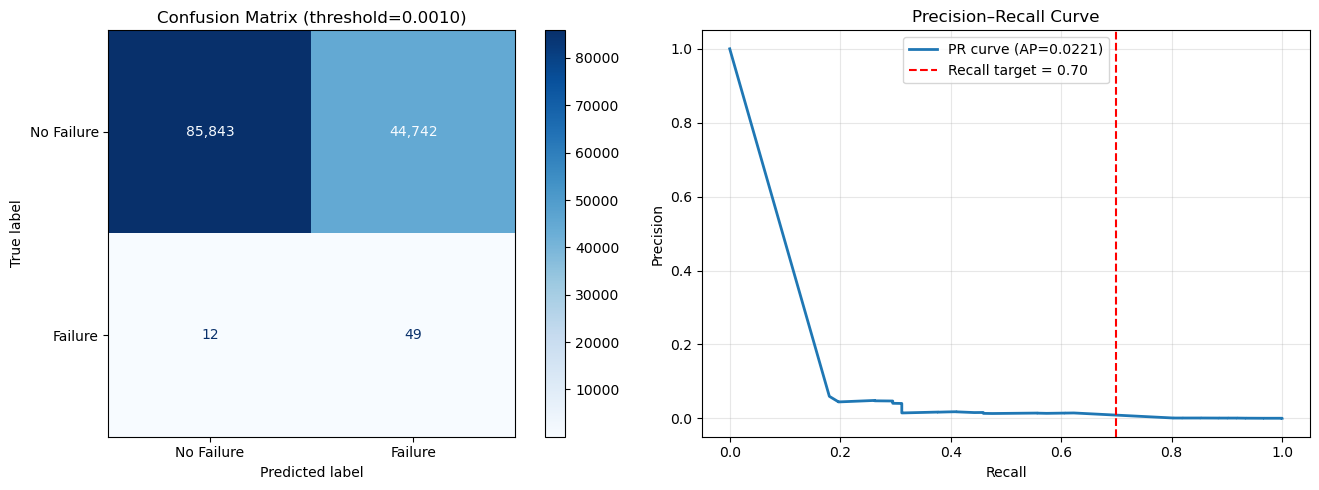

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_curve

# ── Classification Report ────────────────────────────────────────────────────
print("="*80)
print("DETAILED EVALUATION — CLASSIFICATION REPORT")
print("="*80)
print(classification_report(y_eval, y_eval_pred, digits=4,
                            target_names=['No Failure', 'Failure']))

cm = confusion_matrix(y_eval, y_eval_pred)
tn, fp, fn, tp = cm.ravel()
rec = tp/(tp+fn) if (tp+fn) > 0 else 0
prec = tp/(tp+fp) if (tp+fp) > 0 else 0
fpr = fp/(fp+tn) if (fp+tn) > 0 else 0

print(f"  TP={tp}  FP={fp}  FN={fn}  TN={tn}")
print(f"  Recall:             {rec:.4f}  (target: ≥ {target_recall:.2f})")
print(f"  Precision:          {prec:.4f}")
print(f"  False-positive rate: {fpr:.6f}  ({fp:,} false positives)")

# ── Visualisations ───────────────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=['No Failure', 'Failure'])
disp.plot(ax=axes[0], cmap='Blues', values_format=',')
axes[0].set_title(f'Confusion Matrix (threshold={decision_threshold:.4f})')

# Precision-Recall curve with recall target line
prec_curve, rec_curve, _ = precision_recall_curve(y_eval, y_eval_prob)
ap = average_precision_score(y_eval, y_eval_prob)
axes[1].plot(rec_curve, prec_curve, lw=2, label=f'PR curve (AP={ap:.4f})')
axes[1].axvline(x=target_recall, color='r', linestyle='--', label=f'Recall target = {target_recall:.2f}')
axes[1].set_title('Precision–Recall Curve')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Retraining Signal — S3 Flag & Optional SNS

If the quality gates indicate retraining is needed, this cell:
1. **Writes a retraining-trigger JSON** to S3 as an audit trail
2. **Publishes an SNS notification** (if `SNS_TOPIC_ARN` is configured)

> **Note:** Actual retraining and endpoint update are performed automatically by the **SageMaker Pipeline DAG** (Section 13). This cell only records the signal for the interactive notebook run.

In [8]:
# ── Retraining signal based on quality gate results ──────────────────────────
model_package_arn = os.getenv("MODEL_PACKAGE_ARN")
sns_topic_arn = os.getenv("SNS_TOPIC_ARN", "")
run_timestamp = datetime.now().strftime('%Y%m%d-%H%M%S')

print(f"{'='*80}")
print("RETRAINING SIGNAL")
print(f"{'='*80}")

if results["retrain_needed"]:
    # ── Build retraining trigger payload ─────────────────────────────────
    retrain_payload = {
        "trigger":          "model-monitoring-pipeline",
        "timestamp":        run_timestamp,
        "retrain_needed":   True,
        "reasons":          results["retrain_reasons"],
        "model_package_arn": model_package_arn or "N/A",
        "endpoint_name":    os.getenv("ENDPOINT_NAME", "").strip("'\""),
        "recall_on_prod":   results["primary"]["value"],
        "target_recall":    results["primary"]["target"],
        "secondary_failures": [
            {"gate": g["gate"], "value": g["value"], "baseline": g.get("baseline")}
            for g in results["secondary"] if not g["passed"]
        ],
        "drift_issues": [
            g for g in results["data_quality"] if g["action"] == "retrain"
        ],
    }

    # ── Write retrain trigger to S3 ──────────────────────────────────────
    trigger_s3_key = f"monitoring/retrain-triggers/{run_timestamp}/retrain_trigger.json"
    s3_client.put_object(
        Bucket=bucket,
        Key=trigger_s3_key,
        Body=json.dumps(retrain_payload, indent=2, default=str),
        ContentType="application/json",
    )
    print(f"  🔴 RETRAINING TRIGGERED")
    print(f"  S3 trigger:  s3://{bucket}/{trigger_s3_key}")

    # ── Publish SNS notification ─────────────────────────────────────────
    if sns_topic_arn:
        sns_client = boto3.client('sns', region_name=region)
        subject = f"[RETRAIN] HDD Failure Model — Recall={results['primary']['value']:.4f}"
        message_lines = [
            "MODEL RETRAINING REQUIRED",
            "=" * 50,
            f"Timestamp:     {run_timestamp}",
            f"Endpoint:      {retrain_payload['endpoint_name']}",
            f"Model Package: {model_package_arn or 'N/A'}",
            "",
            "REASONS:",
        ]
        for reason in results["retrain_reasons"]:
            message_lines.append(f"  • {reason}")
        message_lines += [
            "",
            f"Recall on production data: {results['primary']['value']:.4f}",
            f"Target recall:             {results['primary']['target']:.2f}",
            "",
            f"Retrain trigger artifact:  s3://{bucket}/{trigger_s3_key}",
        ]

        sns_client.publish(
            TopicArn=sns_topic_arn,
            Subject=subject[:100],
            Message="\n".join(message_lines),
        )
        print(f"  SNS sent:    {sns_topic_arn}")
    else:
        print(f"  SNS:         Not configured (set SNS_TOPIC_ARN in .env)")

    print(f"\n  Reasons:")
    for reason in results["retrain_reasons"]:
        print(f"    • {reason}")

else:
    print(f"  ✅ MODEL HEALTHY — No retraining signal emitted")
    print(f"  The model continues to perform within acceptable bounds.")
    if results["warnings"]:
        print(f"  ({len(results['warnings'])} minor warning(s) — monitor on next run)")
    # No changes to registry — model stays Approved

print(f"\n  Model Registry: UNCHANGED (deployed model stays Approved)")
print(f"{'='*80}")

RETRAINING SIGNAL
  ✅ MODEL HEALTHY — No retraining signal emitted
  The model continues to perform within acceptable bounds.
  (2 minor warning(s) — monitor on next run)

  Model Registry: UNCHANGED (deployed model stays Approved)


## 9. Save Monitoring Results to S3

Persist the production monitoring results as a timestamped JSON artifact in S3. This creates an audit trail of every monitoring run, tracking model health over time.

In [9]:
# ── Serialize and upload monitoring results ───────────────────────────────────
cm = confusion_matrix(y_eval, y_eval_pred)
tn, fp, fn, tp = cm.ravel()
rec = tp/(tp+fn) if (tp+fn) > 0 else 0
prec = tp/(tp+fp) if (tp+fp) > 0 else 0
fpr = fp/(fp+tn) if (fp+tn) > 0 else 0

monitoring_result = {
    "run_timestamp":     run_timestamp,
    "evaluation_data":   eval_fg_name,
    "decision_threshold": decision_threshold,
    "target_recall":     target_recall,
    "retrain_needed":    results["retrain_needed"],
    "retrain_reasons":   results.get("retrain_reasons", []),
    "primary_gate": {
        "metric":   results["primary"]["gate"],
        "passed":   results["primary"]["passed"],
        "value":    results["primary"]["value"],
        "target":   results["primary"]["target"],
        "action":   results["primary"]["action"],
    },
    "secondary_gates": [
        {
            "metric":      g["gate"],
            "passed":      g["passed"],
            "value":       g["value"],
            "target":      g["target"],
            "baseline":    g.get("baseline"),
            "degradation": g.get("degradation", 0),
            "action":      g["action"],
        }
        for g in results["secondary"]
    ],
    "data_quality_issues": [
        g for g in results["data_quality"] if not g["passed"]
    ],
    "confusion_matrix": {"tp": int(tp), "fp": int(fp), "fn": int(fn), "tn": int(tn)},
    "metrics": {
        "recall":    round(float(rec), 6),
        "precision": round(float(prec), 6),
        "fpr":       round(float(fpr), 6),
    },
}

# Upload to S3
result_s3_key = f"monitoring/runs/{run_timestamp}/monitoring_results.json"
s3_client.put_object(
    Bucket=bucket,
    Key=result_s3_key,
    Body=json.dumps(monitoring_result, indent=2, default=str),
    ContentType="application/json",
)
result_s3_uri = f"s3://{bucket}/{result_s3_key}"

print(f"{'='*80}")
print("MONITORING RESULTS SAVED")
print(f"{'='*80}")
print(f"  S3 URI:          {result_s3_uri}")
print(f"  Retrain needed:  {results['retrain_needed']}")
print(f"  Recall:          {rec:.4f}")
print(f"  Precision:       {prec:.4f}")
print(f"  FP count:        {fp}")
if results["retrain_needed"]:
    print(f"  Retrain trigger: s3://{bucket}/monitoring/retrain-triggers/{run_timestamp}/")
print(f"{'='*80}")

MONITORING RESULTS SAVED
  S3 URI:          s3://mlops-backblaze-4263963c-us-east-1/monitoring/runs/20260215-200245/monitoring_results.json
  Retrain needed:  False
  Recall:          0.8033
  Precision:       0.0011
  FP count:        44742


## 10. SageMaker Model Monitor — Schedule (Optional)

Set up a **SageMaker Model Monitor** schedule that automatically evaluates the deployed endpoint on a regular cadence. This cell configures:
- **Data quality monitoring**: Detect feature drift against training baselines
- **Model quality monitoring**: Compare predictions against ground-truth labels when available

> **Note:** This requires an active SageMaker endpoint. Skip this section if you only need the CI/CD gate functions above.

In [10]:
from sagemaker.model_monitor import (
    DefaultModelMonitor,
    CronExpressionGenerator,
    ModelQualityMonitor,
    EndpointInput,
    MonitoringOutput,
)

endpoint_name = os.getenv("ENDPOINT_NAME", "").strip("'\"")

print(f"Endpoint Name: {endpoint_name}")

if not endpoint_name:
    print("⚠ No ENDPOINT_NAME found in .env — skipping Model Monitor schedule.")
    print("  Deploy the model first (base_model.ipynb section 13), then re-run.")
else:
    print(f"Setting up Model Monitor for endpoint: {endpoint_name}")
    
    # ── Data Quality Monitor ─────────────────────────────────────────────────
    data_monitor = DefaultModelMonitor(
        role=role,
        instance_count=1,
        instance_type='ml.m5.xlarge',
        volume_size_in_gb=20,
        max_runtime_in_seconds=3600,
        sagemaker_session=sagemaker_session,
    )
    
    monitor_schedule_name = f"hdd-failure-data-quality-{run_timestamp}"
    
    try:
        data_monitor.create_monitoring_schedule(
            monitor_schedule_name=monitor_schedule_name,
            endpoint_input=endpoint_name,
            output_s3_uri=f"s3://{bucket}/monitoring/data-quality/",
            statistics=baseline_data_quality_s3,
            schedule_cron_expression=CronExpressionGenerator.daily(),
        )
        print(f"  ✓ Data quality schedule created: {monitor_schedule_name}")
    except Exception as e:
        print(f"  ⚠ Data quality schedule failed: {e}")
    
    # ── Model Quality Monitor ────────────────────────────────────────────────
    model_monitor = ModelQualityMonitor(
        role=role,
        instance_count=1,
        instance_type='ml.m5.xlarge',
        volume_size_in_gb=20,
        max_runtime_in_seconds=3600,
        sagemaker_session=sagemaker_session,
    )
    
    mq_schedule_name = f"hdd-failure-model-quality-{run_timestamp}"
    
    try:
        model_monitor.create_monitoring_schedule(
            monitor_schedule_name=mq_schedule_name,
            endpoint_input=EndpointInput(
                endpoint_name=endpoint_name,
                destination="/opt/ml/processing/input/endpoint",
                probability_attribute="probability",
                probability_threshold_attribute=decision_threshold,
            ),
            output_s3_uri=f"s3://{bucket}/monitoring/model-quality/",
            problem_type="BinaryClassification",
            ground_truth_input=f"s3://{bucket}/monitoring/ground-truth/",
            schedule_cron_expression=CronExpressionGenerator.daily(),
        )
        print(f"  ✓ Model quality schedule created: {mq_schedule_name}")
    except Exception as e:
        print(f"  ⚠ Model quality schedule failed: {e}")
    
    print(f"\n{'='*80}")
    print("MODEL MONITOR SCHEDULES")
    print(f"{'='*80}")
    print(f"  Data Quality:  {monitor_schedule_name}")
    print(f"  Model Quality: {mq_schedule_name}")
    print(f"  Frequency:     Daily")
    print(f"{'='*80}")

Endpoint Name: lgb-hdd-failure-endpoint-20260215-185627
Setting up Model Monitor for endpoint: lgb-hdd-failure-endpoint-20260215-185627


  ✓ Data quality schedule created: hdd-failure-data-quality-20260215-200245
  ✓ Model quality schedule created: hdd-failure-model-quality-20260215-200245

MODEL MONITOR SCHEDULES
  Data Quality:  hdd-failure-data-quality-20260215-200245
  Model Quality: hdd-failure-model-quality-20260215-200245
  Frequency:     Daily


## 11. Infrastructure Monitoring — CloudWatch Alarms & Metrics

Set up **infrastructure-level monitoring** for the deployed SageMaker endpoint. This complements the model/data quality monitors above by tracking operational health:

| Metric | Alarm Threshold | Description |
|---|---|---|
| **Invocation 5xx Errors** | ≥ 1 over 5 min | Server-side errors from the endpoint |
| **Invocation 4xx Errors** | ≥ 5 over 5 min | Client-side errors (bad payloads, throttles) |
| **Model Latency (p99)** | ≥ 2 000 ms | 99th-percentile inference latency |
| **Invocations** | 0 over 15 min | Endpoint receiving no traffic (canary check) |
| **CPU Utilization** | ≥ 80 % sustained | Backend instance CPU saturation |
| **Memory Utilization** | ≥ 80 % sustained | Backend instance memory pressure |
| **Disk Utilization** | ≥ 80 % sustained | Backend instance disk pressure |
| **Overhead Latency (p99)** | ≥ 500 ms | SageMaker overhead outside model container |

> **Prerequisites:** An active SageMaker endpoint (`ENDPOINT_NAME` in `.env`). Optionally set `SNS_TOPIC_ARN` to receive alarm notifications via email/Slack.

In [11]:
import boto3
from datetime import datetime, timedelta

cw_client = boto3.client('cloudwatch', region_name=region)
sns_topic_arn = os.getenv("SNS_TOPIC_ARN", "")

if not endpoint_name:
    print("⚠ No ENDPOINT_NAME found in .env — skipping infrastructure monitors.")
    print("  Deploy the model first (base_model.ipynb section 13), then re-run.")
else:
    alarm_prefix = f"hdd-failure-{endpoint_name}"
    alarm_actions = [sns_topic_arn] if sns_topic_arn else []
    alarms_created = []

    if alarm_actions:
        print(f"SNS notifications enabled: {sns_topic_arn}")
    else:
        print("⚠ SNS_TOPIC_ARN not set — alarms created without notification actions.")
        print("  Set SNS_TOPIC_ARN in .env to receive email/Slack alerts.\n")

    # ── Helper to create or update an alarm ──────────────────────────────────
    def create_alarm(name, metric, namespace, stat, period, eval_periods,
                     threshold, comparison, description, dimensions, unit=None,
                     treat_missing="missing"):
        """Create a CloudWatch alarm and return its name."""
        kwargs = dict(
            AlarmName=name,
            AlarmDescription=description,
            Namespace=namespace,
            MetricName=metric,
            Dimensions=dimensions,
            Statistic=stat,
            Period=period,
            EvaluationPeriods=eval_periods,
            Threshold=threshold,
            ComparisonOperator=comparison,
            TreatMissingData=treat_missing,
        )
        if alarm_actions:
            kwargs["AlarmActions"] = alarm_actions
            kwargs["OKActions"] = alarm_actions
        if unit:
            kwargs["Unit"] = unit
        cw_client.put_metric_alarm(**kwargs)
        return name

    endpoint_dims = [{"Name": "EndpointName", "Value": endpoint_name},
                     {"Name": "VariantName", "Value": "AllTraffic"}]

    # ══════════════════════════════════════════════════════════════════════════
    # 1. Invocation 5xx Errors  (server-side failures)
    # ══════════════════════════════════════════════════════════════════════════
    alarms_created.append(create_alarm(
        name=f"{alarm_prefix}-Invocation5xxErrors",
        metric="Invocation5XXErrors",
        namespace="AWS/SageMaker",
        stat="Sum",
        period=300,
        eval_periods=1,
        threshold=1,
        comparison="GreaterThanOrEqualToThreshold",
        description="Fires when the endpoint returns ≥ 1 server-side (5xx) error in 5 minutes.",
        dimensions=endpoint_dims,
        treat_missing="notBreaching",
    ))

    # ══════════════════════════════════════════════════════════════════════════
    # 2. Invocation 4xx Errors  (client-side / throttling)
    # ══════════════════════════════════════════════════════════════════════════
    alarms_created.append(create_alarm(
        name=f"{alarm_prefix}-Invocation4xxErrors",
        metric="Invocation4XXErrors",
        namespace="AWS/SageMaker",
        stat="Sum",
        period=300,
        eval_periods=1,
        threshold=5,
        comparison="GreaterThanOrEqualToThreshold",
        description="Fires when the endpoint returns ≥ 5 client-side (4xx) errors in 5 minutes.",
        dimensions=endpoint_dims,
        treat_missing="notBreaching",
    ))

    # ══════════════════════════════════════════════════════════════════════════
    # 3. Model Latency p99  (inference time inside the container)
    # ══════════════════════════════════════════════════════════════════════════
    # p99 requires ExtendedStatistic; Statistic is not used
    cw_client.put_metric_alarm(
        AlarmName=f"{alarm_prefix}-ModelLatencyP99",
        AlarmDescription="Fires when p99 model inference latency ≥ 2 000 ms over 5 minutes.",
        Namespace="AWS/SageMaker",
        MetricName="ModelLatency",
        Dimensions=endpoint_dims,
        ExtendedStatistic="p99",
        Period=300,
        EvaluationPeriods=2,
        Threshold=2_000_000,  # microseconds
        ComparisonOperator="GreaterThanOrEqualToThreshold",
        TreatMissingData="missing",
        **({"AlarmActions": alarm_actions, "OKActions": alarm_actions} if alarm_actions else {}),
    )
    alarms_created.append(f"{alarm_prefix}-ModelLatencyP99")

    # ══════════════════════════════════════════════════════════════════════════
    # 4. Overhead Latency p99  (SageMaker routing overhead)
    # ══════════════════════════════════════════════════════════════════════════
    cw_client.put_metric_alarm(
        AlarmName=f"{alarm_prefix}-OverheadLatencyP99",
        AlarmDescription="Fires when p99 SageMaker overhead latency ≥ 500 ms over 5 minutes.",
        Namespace="AWS/SageMaker",
        MetricName="OverheadLatency",
        Dimensions=endpoint_dims,
        ExtendedStatistic="p99",
        Period=300,
        EvaluationPeriods=2,
        Threshold=500_000,  # microseconds
        ComparisonOperator="GreaterThanOrEqualToThreshold",
        TreatMissingData="missing",
        **({"AlarmActions": alarm_actions, "OKActions": alarm_actions} if alarm_actions else {}),
    )
    alarms_created.append(f"{alarm_prefix}-OverheadLatencyP99")

    # ══════════════════════════════════════════════════════════════════════════
    # 5. Zero-Traffic Canary  (no invocations for 15 min)
    # ══════════════════════════════════════════════════════════════════════════
    alarms_created.append(create_alarm(
        name=f"{alarm_prefix}-NoInvocations",
        metric="Invocations",
        namespace="AWS/SageMaker",
        stat="Sum",
        period=300,
        eval_periods=3,
        threshold=1,
        comparison="LessThanThreshold",
        description="Fires when the endpoint receives 0 invocations for 15 minutes (canary).",
        dimensions=endpoint_dims,
        treat_missing="breaching",
    ))

    # ══════════════════════════════════════════════════════════════════════════
    # 6. CPU Utilization  (per-instance via /aws/sagemaker/Endpoints)
    # ══════════════════════════════════════════════════════════════════════════
    instance_dims = [{"Name": "EndpointName", "Value": endpoint_name},
                     {"Name": "VariantName", "Value": "AllTraffic"}]

    alarms_created.append(create_alarm(
        name=f"{alarm_prefix}-CPUUtilization",
        metric="CPUUtilization",
        namespace="/aws/sagemaker/Endpoints",
        stat="Average",
        period=300,
        eval_periods=3,
        threshold=80.0,
        comparison="GreaterThanOrEqualToThreshold",
        description="Fires when average CPU utilization ≥ 80 % for 15 minutes.",
        dimensions=instance_dims,
        unit="Percent",
    ))

    # ══════════════════════════════════════════════════════════════════════════
    # 7. Memory Utilization
    # ══════════════════════════════════════════════════════════════════════════
    alarms_created.append(create_alarm(
        name=f"{alarm_prefix}-MemoryUtilization",
        metric="MemoryUtilization",
        namespace="/aws/sagemaker/Endpoints",
        stat="Average",
        period=300,
        eval_periods=3,
        threshold=80.0,
        comparison="GreaterThanOrEqualToThreshold",
        description="Fires when average memory utilization ≥ 80 % for 15 minutes.",
        dimensions=instance_dims,
        unit="Percent",
    ))

    # ══════════════════════════════════════════════════════════════════════════
    # 8. Disk Utilization
    # ══════════════════════════════════════════════════════════════════════════
    alarms_created.append(create_alarm(
        name=f"{alarm_prefix}-DiskUtilization",
        metric="DiskUtilization",
        namespace="/aws/sagemaker/Endpoints",
        stat="Average",
        period=300,
        eval_periods=3,
        threshold=80.0,
        comparison="GreaterThanOrEqualToThreshold",
        description="Fires when average disk utilization ≥ 80 % for 15 minutes.",
        dimensions=instance_dims,
        unit="Percent",
    ))

    # ══════════════════════════════════════════════════════════════════════════
    # Fetch current alarm states
    # ══════════════════════════════════════════════════════════════════════════
    print(f"{'='*80}")
    print("INFRASTRUCTURE MONITORING — CLOUDWATCH ALARMS")
    print(f"{'='*80}")

    resp = cw_client.describe_alarms(AlarmNames=alarms_created)
    for alarm in resp.get("MetricAlarms", []):
        state = alarm["StateValue"]
        icon = {"OK": "✅", "ALARM": "🔴", "INSUFFICIENT_DATA": "⚪"}.get(state, "❓")
        short_name = alarm["AlarmName"].replace(alarm_prefix + "-", "")
        ns = alarm["Namespace"]
        metric = alarm["MetricName"]
        threshold = alarm["Threshold"]
        print(f"  {icon} {short_name:30s}  state={state:20s}  "
              f"metric={ns}/{metric}  threshold={threshold}")

    print(f"\n  Total alarms created/updated: {len(alarms_created)}")
    if alarm_actions:
        print(f"  Notifications:  {sns_topic_arn}")
    else:
        print(f"  Notifications:  NONE (set SNS_TOPIC_ARN in .env)")

    # ── Fetch recent invocation metrics (last 1 hour) ────────────────────────
    print(f"\n{'─'*80}")
    print("  RECENT ENDPOINT METRICS (last 1 hour)")
    print(f"{'─'*80}")

    now = datetime.utcnow()
    metrics_to_fetch = [
        ("Invocations",        "AWS/SageMaker", "Sum"),
        ("Invocation5XXErrors", "AWS/SageMaker", "Sum"),
        ("Invocation4XXErrors", "AWS/SageMaker", "Sum"),
        ("ModelLatency",       "AWS/SageMaker", "Average"),
        ("OverheadLatency",    "AWS/SageMaker", "Average"),
        ("CPUUtilization",     "/aws/sagemaker/Endpoints", "Average"),
        ("MemoryUtilization",  "/aws/sagemaker/Endpoints", "Average"),
        ("DiskUtilization",    "/aws/sagemaker/Endpoints", "Average"),
    ]

    for metric_name, namespace, stat in metrics_to_fetch:
        try:
            result = cw_client.get_metric_statistics(
                Namespace=namespace,
                MetricName=metric_name,
                Dimensions=endpoint_dims if namespace == "AWS/SageMaker" else instance_dims,
                StartTime=now - timedelta(hours=1),
                EndTime=now,
                Period=3600,
                Statistics=[stat],
            )
            dps = result.get("Datapoints", [])
            if dps:
                val = dps[-1][stat]
                unit_label = ""
                if "Latency" in metric_name:
                    val_display = f"{val/1000:.1f} ms"
                elif "Utilization" in metric_name:
                    val_display = f"{val:.1f} %"
                else:
                    val_display = f"{val:,.0f}"
                print(f"    {metric_name:25s}  {stat:8s} = {val_display}")
            else:
                print(f"    {metric_name:25s}  {stat:8s} = — (no data)")
        except Exception as e:
            print(f"    {metric_name:25s}  error: {e}")

    print(f"{'='*80}")

⚠ SNS_TOPIC_ARN not set — alarms created without notification actions.
  Set SNS_TOPIC_ARN in .env to receive email/Slack alerts.

INFRASTRUCTURE MONITORING — CLOUDWATCH ALARMS
  ⚪ CPUUtilization                  state=INSUFFICIENT_DATA     metric=/aws/sagemaker/Endpoints/CPUUtilization  threshold=80.0
  ⚪ DiskUtilization                 state=INSUFFICIENT_DATA     metric=/aws/sagemaker/Endpoints/DiskUtilization  threshold=80.0
  ⚪ Invocation4xxErrors             state=INSUFFICIENT_DATA     metric=AWS/SageMaker/Invocation4XXErrors  threshold=5.0
  ⚪ Invocation5xxErrors             state=INSUFFICIENT_DATA     metric=AWS/SageMaker/Invocation5XXErrors  threshold=1.0
  ⚪ MemoryUtilization               state=INSUFFICIENT_DATA     metric=/aws/sagemaker/Endpoints/MemoryUtilization  threshold=80.0
  ⚪ ModelLatencyP99                 state=INSUFFICIENT_DATA     metric=AWS/SageMaker/ModelLatency  threshold=2000000.0
  ⚪ NoInvocations                   state=INSUFFICIENT_DATA     metric=AWS/Sage

/tmp/ipykernel_3288/2011787246.py:223: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  now = datetime.utcnow()


## 12. CloudWatch Dashboard

Create a **CloudWatch dashboard** that consolidates all endpoint infrastructure metrics into a single pane of glass. The dashboard includes:

- **Invocation volume & errors** (5xx / 4xx) over time
- **Model latency** (average and p99)
- **Overhead latency** (SageMaker routing)
- **Resource utilization** (CPU, memory, disk)
- **Alarm status widget** for all infrastructure alarms

In [12]:
# ── Build CloudWatch Dashboard ────────────────────────────────────────────────
dashboard_name = f"HDD-Failure-Endpoint-{endpoint_name}"

if not endpoint_name:
    print("⚠ No ENDPOINT_NAME found — skipping dashboard creation.")
else:
    # Widget dimensions
    W_FULL = 24   # full row width
    W_HALF = 12
    W_THIRD = 8
    H = 6         # standard widget height

    # Shared metric props
    sm_ns = "AWS/SageMaker"
    ep_ns = "/aws/sagemaker/Endpoints"
    ep_dims = {"EndpointName": endpoint_name, "VariantName": "AllTraffic"}
    dim_list = [d for pair in ep_dims.items() for d in pair]  # flattened for CW JSON

    dashboard_body = {
        "widgets": [
            # ── Row 1: Title ──────────────────────────────────────────────
            {
                "type": "text",
                "x": 0, "y": 0,
                "width": W_FULL, "height": 2,
                "properties": {
                    "markdown": (
                        f"# HDD Failure Prediction — Endpoint Dashboard\n"
                        f"**Endpoint:** `{endpoint_name}` &nbsp;|&nbsp; "
                        f"**Region:** `{region}` &nbsp;|&nbsp; "
                        f"**Threshold:** `{decision_threshold:.6f}`"
                    )
                }
            },

            # ── Row 2: Invocations & Errors ───────────────────────────────
            {
                "type": "metric",
                "x": 0, "y": 2,
                "width": W_HALF, "height": H,
                "properties": {
                    "title": "Invocations",
                    "metrics": [
                        [sm_ns, "Invocations", *dim_list, {"stat": "Sum", "label": "Invocations"}],
                    ],
                    "view": "timeSeries",
                    "region": region,
                    "period": 300,
                    "stat": "Sum",
                }
            },
            {
                "type": "metric",
                "x": W_HALF, "y": 2,
                "width": W_HALF, "height": H,
                "properties": {
                    "title": "Invocation Errors",
                    "metrics": [
                        [sm_ns, "Invocation5XXErrors", *dim_list,
                         {"stat": "Sum", "label": "5xx Errors", "color": "#d62728"}],
                        [sm_ns, "Invocation4XXErrors", *dim_list,
                         {"stat": "Sum", "label": "4xx Errors", "color": "#ff7f0e"}],
                    ],
                    "view": "timeSeries",
                    "region": region,
                    "period": 300,
                    "stat": "Sum",
                }
            },

            # ── Row 3: Latency ────────────────────────────────────────────
            {
                "type": "metric",
                "x": 0, "y": 8,
                "width": W_HALF, "height": H,
                "properties": {
                    "title": "Model Latency (ms)",
                    "metrics": [
                        [sm_ns, "ModelLatency", *dim_list,
                         {"stat": "Average", "label": "Avg"}],
                        [sm_ns, "ModelLatency", *dim_list,
                         {"stat": "p99", "label": "p99"}],
                        [sm_ns, "ModelLatency", *dim_list,
                         {"stat": "p50", "label": "p50"}],
                    ],
                    "view": "timeSeries",
                    "region": region,
                    "period": 300,
                    "yAxis": {"left": {"label": "Microseconds"}},
                }
            },
            {
                "type": "metric",
                "x": W_HALF, "y": 8,
                "width": W_HALF, "height": H,
                "properties": {
                    "title": "Overhead Latency (ms)",
                    "metrics": [
                        [sm_ns, "OverheadLatency", *dim_list,
                         {"stat": "Average", "label": "Avg"}],
                        [sm_ns, "OverheadLatency", *dim_list,
                         {"stat": "p99", "label": "p99"}],
                    ],
                    "view": "timeSeries",
                    "region": region,
                    "period": 300,
                    "yAxis": {"left": {"label": "Microseconds"}},
                }
            },

            # ── Row 4: Resource Utilization ───────────────────────────────
            {
                "type": "metric",
                "x": 0, "y": 14,
                "width": W_THIRD, "height": H,
                "properties": {
                    "title": "CPU Utilization (%)",
                    "metrics": [
                        [ep_ns, "CPUUtilization", *dim_list,
                         {"stat": "Average", "label": "CPU Avg"}],
                        [ep_ns, "CPUUtilization", *dim_list,
                         {"stat": "Maximum", "label": "CPU Max"}],
                    ],
                    "view": "timeSeries",
                    "region": region,
                    "period": 300,
                    "yAxis": {"left": {"min": 0, "max": 100}},
                    "annotations": {
                        "horizontal": [
                            {"label": "Alarm @ 80%", "value": 80, "color": "#d62728"}
                        ]
                    },
                }
            },
            {
                "type": "metric",
                "x": W_THIRD, "y": 14,
                "width": W_THIRD, "height": H,
                "properties": {
                    "title": "Memory Utilization (%)",
                    "metrics": [
                        [ep_ns, "MemoryUtilization", *dim_list,
                         {"stat": "Average", "label": "Mem Avg"}],
                        [ep_ns, "MemoryUtilization", *dim_list,
                         {"stat": "Maximum", "label": "Mem Max"}],
                    ],
                    "view": "timeSeries",
                    "region": region,
                    "period": 300,
                    "yAxis": {"left": {"min": 0, "max": 100}},
                    "annotations": {
                        "horizontal": [
                            {"label": "Alarm @ 80%", "value": 80, "color": "#d62728"}
                        ]
                    },
                }
            },
            {
                "type": "metric",
                "x": 2 * W_THIRD, "y": 14,
                "width": W_THIRD, "height": H,
                "properties": {
                    "title": "Disk Utilization (%)",
                    "metrics": [
                        [ep_ns, "DiskUtilization", *dim_list,
                         {"stat": "Average", "label": "Disk Avg"}],
                        [ep_ns, "DiskUtilization", *dim_list,
                         {"stat": "Maximum", "label": "Disk Max"}],
                    ],
                    "view": "timeSeries",
                    "region": region,
                    "period": 300,
                    "yAxis": {"left": {"min": 0, "max": 100}},
                    "annotations": {
                        "horizontal": [
                            {"label": "Alarm @ 80%", "value": 80, "color": "#d62728"}
                        ]
                    },
                }
            },

            # ── Row 5: Alarm Status ───────────────────────────────────────
            {
                "type": "alarm",
                "x": 0, "y": 20,
                "width": W_FULL, "height": 3,
                "properties": {
                    "title": "Infrastructure Alarm Status",
                    "alarms": [
                        f"arn:aws:cloudwatch:{region}:{boto3.client('sts').get_caller_identity()['Account']}:alarm:{a}"
                        for a in alarms_created
                    ],
                }
            },

            # ── Row 6: Single-value gauges ────────────────────────────────
            {
                "type": "metric",
                "x": 0, "y": 23,
                "width": 6, "height": 4,
                "properties": {
                    "title": "Invocations (last 1h)",
                    "metrics": [
                        [sm_ns, "Invocations", *dim_list, {"stat": "Sum"}],
                    ],
                    "view": "singleValue",
                    "region": region,
                    "period": 3600,
                }
            },
            {
                "type": "metric",
                "x": 6, "y": 23,
                "width": 6, "height": 4,
                "properties": {
                    "title": "5xx Errors (last 1h)",
                    "metrics": [
                        [sm_ns, "Invocation5XXErrors", *dim_list, {"stat": "Sum"}],
                    ],
                    "view": "singleValue",
                    "region": region,
                    "period": 3600,
                }
            },
            {
                "type": "metric",
                "x": 12, "y": 23,
                "width": 6, "height": 4,
                "properties": {
                    "title": "Avg Model Latency (last 1h)",
                    "metrics": [
                        [sm_ns, "ModelLatency", *dim_list, {"stat": "Average"}],
                    ],
                    "view": "singleValue",
                    "region": region,
                    "period": 3600,
                }
            },
            {
                "type": "metric",
                "x": 18, "y": 23,
                "width": 6, "height": 4,
                "properties": {
                    "title": "CPU Utilization (last 1h)",
                    "metrics": [
                        [ep_ns, "CPUUtilization", *dim_list, {"stat": "Average"}],
                    ],
                    "view": "singleValue",
                    "region": region,
                    "period": 3600,
                }
            },
        ]
    }

    # ── Create or update the dashboard ───────────────────────────────────────
    cw_client.put_dashboard(
        DashboardName=dashboard_name,
        DashboardBody=json.dumps(dashboard_body),
    )

    dashboard_url = (
        f"https://{region}.console.aws.amazon.com/cloudwatch/home"
        f"?region={region}#dashboards:name={dashboard_name}"
    )

    print(f"{'='*80}")
    print("CLOUDWATCH DASHBOARD CREATED")
    print(f"{'='*80}")
    print(f"  Dashboard:  {dashboard_name}")
    print(f"  Region:     {region}")
    print(f"  Widgets:    {len(dashboard_body['widgets'])}")
    print(f"  Console:    {dashboard_url}")
    print(f"\n  Layout:")
    print(f"    Row 1  — Header with endpoint info")
    print(f"    Row 2  — Invocation count & error rates (5xx / 4xx)")
    print(f"    Row 3  — Model latency (avg/p50/p99) & overhead latency")
    print(f"    Row 4  — CPU / Memory / Disk utilization with 80% alarm line")
    print(f"    Row 5  — Alarm status widget (all 8 infrastructure alarms)")
    print(f"    Row 6  — Single-value gauges (invocations, errors, latency, CPU)")
    print(f"{'='*80}")

CLOUDWATCH DASHBOARD CREATED
  Dashboard:  HDD-Failure-Endpoint-lgb-hdd-failure-endpoint-20260215-185627
  Region:     us-east-1
  Widgets:    13
  Console:    https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#dashboards:name=HDD-Failure-Endpoint-lgb-hdd-failure-endpoint-20260215-185627

  Layout:
    Row 1  — Header with endpoint info
    Row 2  — Invocation count & error rates (5xx / 4xx)
    Row 3  — Model latency (avg/p50/p99) & overhead latency
    Row 4  — CPU / Memory / Disk utilization with 80% alarm line
    Row 5  — Alarm status widget (all 8 infrastructure alarms)
    Row 6  — Single-value gauges (invocations, errors, latency, CPU)


## 13. SageMaker Pipeline DAG — Automated Monitoring & Retraining

Register the full monitoring-to-retraining pipeline as a **SageMaker Pipeline** DAG. When retraining is triggered, the pipeline **automatically retrains LightGBM, packages the model, deploys it to the endpoint, and registers it in Model Registry** — no manual intervention required.

**DAG Steps:**
1. **EvaluateProductionData** — Query Feature Store, run inference, check quality gates
2. **CheckRetraining** — Branch on evaluation result
3. **RetrainAndDeploy** (RETRAIN branch) — Retrain LightGBM, deploy to endpoint, register model
4. **SaveHealthyReport** (HEALTHY branch) — Log healthy status to S3

In [13]:
# ══════════════════════════════════════════════════════════════════════════════
# SAGEMAKER PIPELINE — Monitoring, Retraining & Deployment DAG
# ══════════════════════════════════════════════════════════════════════════════
#
#   ┌──────────────────────────┐
#   │  EvaluateProductionData  │  Feature Store → inference → quality gates
#   │     (ProcessingStep)     │
#   └────────────┬─────────────┘
#                │
#   ┌────────────▼─────────────┐
#   │     CheckRetraining      │  status == "RETRAIN" ?
#   │     (ConditionStep)      │
#   └──────┬───────────┬───────┘
#     [YES]│           │[NO]
#   ┌──────▼──────┐ ┌──▼─────────────┐
#   │  Retrain &  │ │  SaveHealthy   │
#   │  Deploy     │ │    Report      │
#   └─────────────┘ └────────────────┘
#
# ══════════════════════════════════════════════════════════════════════════════

import os, json
from dotenv import load_dotenv
load_dotenv(ENV_PATH, override=True)

from sagemaker.workflow.pipeline import Pipeline
from sagemaker.workflow.pipeline_context import PipelineSession
from sagemaker.workflow.steps import ProcessingStep
from sagemaker.workflow.condition_step import ConditionStep
from sagemaker.workflow.conditions import ConditionEquals
from sagemaker.workflow.parameters import ParameterString
from sagemaker.workflow.properties import PropertyFile
from sagemaker.workflow.functions import JsonGet
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput

# ── Current values from .env ─────────────────────────────────────────────────
ep_name   = os.getenv("ENDPOINT_NAME")
bkt       = os.getenv("BUCKET_NAME")
fg_p      = os.getenv("FEATURE_GROUP_PROD")
fg_train  = os.getenv("FEATURE_GROUP_TRAIN")
fg_val    = os.getenv("FEATURE_GROUP_VAL")
model_uri = os.getenv("MODEL_S3_URI")
const_uri = os.getenv("MONITORING_CONSTRAINTS_S3")
rl        = os.getenv("SAGEMAKER_ROLE")
mpg       = os.getenv("MODEL_PACKAGE_GROUP", "hdd-failure-prediction")

print(f"Endpoint:      {ep_name}")
print(f"Model S3:      {model_uri}")
print(f"Constraints:   {const_uri}")
print(f"Prod FG:       {fg_p}")
print(f"Train FG:      {fg_train}")
print(f"Val FG:        {fg_val}")
print(f"Pkg Group:     {mpg}\n")

# ── 1. Pipeline Parameters ──────────────────────────────────────────────────
param_endpoint  = ParameterString(name="EndpointName",       default_value=ep_name)
param_bucket    = ParameterString(name="BucketName",         default_value=bkt)
param_recall    = ParameterString(name="TargetRecall",       default_value="0.70")
param_fg_prod   = ParameterString(name="FeatureGroupProd",   default_value=fg_p)
param_fg_train  = ParameterString(name="FeatureGroupTrain",  default_value=fg_train)
param_fg_val    = ParameterString(name="FeatureGroupVal",    default_value=fg_val)
param_role      = ParameterString(name="SageMakerRole",      default_value=rl)
param_pkg_group = ParameterString(name="ModelPackageGroup",  default_value=mpg)
param_force_retrain = ParameterString(name="ForceRetrain",      default_value=str(FORCE_RETRAIN).lower())
param_force_skip    = ParameterString(name="ForceSkipRetrain",  default_value=str(FORCE_SKIP_RETRAIN).lower())

# ── 2. Pipeline Processing Scripts ──────────────────────────────────────────
os.makedirs("pipeline_scripts", exist_ok=True)

# --- evaluate_production.py ─────────────────────────────────────────────────
EVAL_SCRIPT = '''#!/usr/bin/env python3
"""Evaluate LightGBM model on production Feature Store data."""
import subprocess, sys
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "lightgbm"])

import argparse, json, os, tarfile, numpy as np
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, average_precision_score

def main():
    p = argparse.ArgumentParser()
    p.add_argument("--bucket",        required=True)
    p.add_argument("--fg-prod",       required=True)
    p.add_argument("--target-recall", type=float, default=0.70)
    p.add_argument("--region",        default="us-east-1")
    p.add_argument("--force-retrain",      default="false")
    p.add_argument("--force-skip-retrain", default="false")
    args = p.parse_args()

    # Load constraints
    cdir = "/opt/ml/processing/input/constraints"
    with open(os.path.join(cdir, os.listdir(cdir)[0])) as f:
        constraints = json.load(f)

    # Load model
    mdir = "/opt/ml/processing/input/model"
    tar_path = os.path.join(mdir, [f for f in os.listdir(mdir) if f.endswith(".tar.gz")][0])
    with tarfile.open(tar_path, "r:gz") as tar:
        tar.extractall("/tmp/model")
    model = lgb.Booster(model_file="/tmp/model/lgb_model.txt")
    with open("/tmp/model/model_metadata.json") as f:
        threshold = json.load(f)["threshold"]

    # Load production data from Feature Store
    import sagemaker
    from sagemaker.feature_store.feature_group import FeatureGroup
    fg = FeatureGroup(name=args.fg_prod, sagemaker_session=sagemaker.Session())
    q = fg.athena_query()
    q.run(f\'SELECT * FROM "{q.table_name}"\',
          output_location=f"s3://{args.bucket}/athena-results/pipeline/")
    q.wait()
    df = q.as_dataframe()

    feature_cols = constraints["feature_cols"]
    X = df[feature_cols].astype(float).values
    y = df["failure"].astype(int).values

    probs = model.predict(X)
    preds = (probs >= threshold).astype(int)
    tp = int(((preds==1)&(y==1)).sum())
    fp = int(((preds==1)&(y==0)).sum())
    fn = int(((preds==0)&(y==1)).sum())
    tn = int(((preds==0)&(y==0)).sum())
    recall    = tp / max(tp+fn, 1)
    precision = tp / max(tp+fp, 1)
    both = len(np.unique(y)) > 1
    roc_auc  = float(roc_auc_score(y, probs)) if both else 0.0
    avg_prec = float(average_precision_score(y, probs)) if both else 0.0

    retrain, reasons = False, []
    if recall < args.target_recall:
        retrain = True
        reasons.append(f"Recall {recall:.4f} < {args.target_recall}")

    bl = constraints.get("baselines", {})
    deg = sum([fp > bl.get("max_false_positives", float("inf")),
               roc_auc < bl.get("min_roc_auc", 0),
               avg_prec < bl.get("min_average_precision", 0)])
    if deg >= 2:
        retrain = True
        reasons.append(f"{deg} secondary metrics regressed")

    nulls = [c for c in feature_cols if float(df[c].isnull().mean()) > 0.05]
    if nulls:
        retrain = True
        reasons.append(f"High null rate: {nulls}")

    # ── Apply override parameters ────────────────────────────────────────────
    force_retrain = args.force_retrain.lower() == "true"
    force_skip    = args.force_skip_retrain.lower() == "true"
    if force_retrain and force_skip:
        retrain = False
        reasons = ["Suppressed by ForceSkipRetrain (conflict with ForceRetrain)"]
    elif force_retrain:
        retrain = True
        reasons.append("ForceRetrain override enabled")
    elif force_skip:
        retrain = False
        reasons = ["Suppressed by ForceSkipRetrain override"]

    result = dict(status="RETRAIN" if retrain else "HEALTHY",
                  recall=recall, precision=precision, roc_auc=roc_auc,
                  avg_precision=avg_prec, tp=tp, fp=fp, fn=fn, tn=tn,
                  degraded=int(deg), reasons=reasons, samples=len(y),
                  force_retrain=force_retrain, force_skip_retrain=force_skip)

    out = "/opt/ml/processing/output"
    os.makedirs(out, exist_ok=True)
    with open(os.path.join(out, "evaluation.json"), "w") as f:
        json.dump(result, f, indent=2)
    print(json.dumps(result, indent=2))

if __name__ == "__main__":
    main()
'''

# --- retrain_and_deploy.py ──────────────────────────────────────────────────
RETRAIN_SCRIPT = '''#!/usr/bin/env python3
"""
Retrain LightGBM on training Feature Store data, package, deploy to the
existing SageMaker endpoint, and register in Model Registry.
"""
import subprocess, sys
subprocess.check_call([sys.executable, "-m", "pip", "install", "-q",
                       "lightgbm", "sagemaker"])

import argparse, json, os, tarfile, shutil, time, boto3, numpy as np
import lightgbm as lgb
from datetime import datetime
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             precision_recall_curve)

def main():
    p = argparse.ArgumentParser()
    p.add_argument("--bucket",              required=True)
    p.add_argument("--endpoint-name",       required=True)
    p.add_argument("--fg-train",            required=True)
    p.add_argument("--fg-val",              required=True)
    p.add_argument("--target-recall",       type=float, default=0.70)
    p.add_argument("--role",                required=True)
    p.add_argument("--model-package-group", required=True)
    p.add_argument("--region",              default="us-east-1")
    args = p.parse_args()

    import sagemaker
    from sagemaker.feature_store.feature_group import FeatureGroup
    from sagemaker.sklearn import SKLearnModel
    from sagemaker.model_monitor import DataCaptureConfig

    sess = sagemaker.Session()
    s3   = boto3.client("s3", region_name=args.region)
    sm   = boto3.client("sagemaker", region_name=args.region)
    ts   = datetime.utcnow().strftime("%Y%m%d-%H%M%S")

    # ── 1. Load training and validation data from Feature Store ─────────────
    print("Loading training data from Feature Store...")
    feature_cols = ["pct_one_star", "pct_two_star", "smart_5_raw",
                    "smart_187_raw", "smart_188_raw", "smart_197_raw",
                    "smart_198_raw"]

    def load_fg(name):
        fg = FeatureGroup(name=name, sagemaker_session=sess)
        q = fg.athena_query()
        q.run(f\'SELECT * FROM "{q.table_name}"\',
              output_location=f"s3://{args.bucket}/athena-results/pipeline/")
        q.wait()
        return q.as_dataframe()

    df_train = load_fg(args.fg_train)
    df_val   = load_fg(args.fg_val)

    X_train = df_train[feature_cols].astype(float)
    y_train = df_train["failure"].astype(int)
    X_val   = df_val[feature_cols].astype(float)
    y_val   = df_val["failure"].astype(int)

    print(f"  Train: {X_train.shape}, positives: {y_train.sum()}")
    print(f"  Val:   {X_val.shape}, positives: {y_val.sum()}")

    # ── 2. Train LightGBM ───────────────────────────────────────────────────
    n_neg = int((y_train == 0).sum())
    n_pos = int((y_train == 1).sum())
    scale_pos = float(np.sqrt(n_neg / max(n_pos, 1)))

    params = dict(
        objective="binary", metric="auc", boosting_type="gbdt",
        scale_pos_weight=scale_pos, learning_rate=0.01, num_leaves=15,
        max_depth=4, min_child_samples=10, min_child_weight=1e-3,
        subsample=0.7, colsample_bytree=0.7, reg_alpha=1.0, reg_lambda=5.0,
        max_bin=127, verbose=-1, seed=42, force_row_wise=True,
    )

    lgb_train = lgb.Dataset(X_train, label=y_train)
    lgb_val   = lgb.Dataset(X_val, label=y_val, reference=lgb_train)

    model = lgb.train(params, lgb_train, num_boost_round=3000,
                      valid_sets=[lgb_val], valid_names=["val"],
                      callbacks=[lgb.early_stopping(300), lgb.log_evaluation(200)])

    print(f"  Best iteration: {model.best_iteration}")
    print(f"  Best val AUC:   {model.best_score['val']['auc']:.4f}")

    # ── 3. Tune threshold for target recall ──────────────────────────────────
    y_val_prob = model.predict(X_val, num_iteration=model.best_iteration)
    precs, recs, threshs = precision_recall_curve(y_val, y_val_prob)

    candidates = []
    for pr, rc, th in zip(precs[:-1], recs[:-1], threshs):
        if rc >= args.target_recall:
            fp_cnt = int(((y_val_prob >= th).astype(int) & (y_val == 0).values).sum())
            candidates.append((th, rc, pr, fp_cnt))
    if candidates:
        candidates.sort(key=lambda x: (x[3], -x[1]))
        best_thresh = candidates[0][0]
    else:
        idx = np.argmin(np.abs(recs[:-1] - args.target_recall))
        best_thresh = float(threshs[idx])

    print(f"  Threshold: {best_thresh:.6f}")

    # ── 4. Package model artifacts ───────────────────────────────────────────
    work = "/tmp/retrain_artifacts"
    os.makedirs(work, exist_ok=True)

    model_file = os.path.join(work, "lgb_model.txt")
    model.save_model(model_file)

    meta = dict(threshold=float(best_thresh), target_recall=args.target_recall,
                feature_cols=feature_cols, best_iteration=model.best_iteration,
                scale_pos_weight=float(scale_pos),
                trained_date=datetime.utcnow().isoformat(),
                retrained_by="sagemaker-pipeline")
    meta_file = os.path.join(work, "model_metadata.json")
    with open(meta_file, "w") as f:
        json.dump(meta, f, indent=2)

    # Copy inference.py from processing input
    inf_src = "/opt/ml/processing/input/inference/inference.py"
    inf_dst = os.path.join(work, "inference.py")
    if os.path.exists(inf_src):
        shutil.copy2(inf_src, inf_dst)
    else:
        raise FileNotFoundError("inference.py not provided as processing input")

    tar_path = os.path.join(work, "model.tar.gz")
    with tarfile.open(tar_path, "w:gz") as tar:
        tar.add(model_file, arcname="lgb_model.txt")
        tar.add(meta_file,  arcname="model_metadata.json")

    model_s3_key = f"models/lgb-hdd-failure/{ts}/model.tar.gz"
    s3.upload_file(tar_path, args.bucket, model_s3_key)
    model_s3_uri = f"s3://{args.bucket}/{model_s3_key}"
    print(f"  Model uploaded: {model_s3_uri}")

    # ── 5. Create SageMaker model + deploy to existing endpoint ──────────────
    model_name = f"lgb-hdd-failure-{ts}"

    sklearn_model = SKLearnModel(
        model_data=model_s3_uri,
        role=args.role,
        entry_point=inf_dst,
        framework_version="1.2-1",
        py_version="py3",
        name=model_name,
        sagemaker_session=sess,
        dependencies=["/opt/ml/processing/input/inference/requirements.txt"],
    )

    data_capture_config = DataCaptureConfig(
        enable_capture=True,
        sampling_percentage=100,
        destination_s3_uri=f"s3://{args.bucket}/monitoring/data-capture/{model_name}",
        capture_options=["Input", "Output"],
        csv_content_types=["text/csv"],
        json_content_types=["application/json"],
    )

    # Create the model in SageMaker
    container_def = sklearn_model.prepare_container_def(instance_type="ml.m5.large")
    sm.create_model(
        ModelName=model_name,
        PrimaryContainer=container_def,
        ExecutionRoleArn=args.role,
    )
    print(f"  SageMaker model created: {model_name}")

    # Create new endpoint config with data capture
    ep_config_name = f"{model_name}-config"
    sm.create_endpoint_config(
        EndpointConfigName=ep_config_name,
        ProductionVariants=[dict(
            VariantName="AllTraffic",
            ModelName=model_name,
            InstanceType="ml.m5.large",
            InitialInstanceCount=1,
            InitialVariantWeight=1.0,
        )],
        DataCaptureConfig=dict(
            EnableCapture=True,
            InitialSamplingPercentage=100,
            DestinationS3Uri=f"s3://{args.bucket}/monitoring/data-capture/{model_name}",
            CaptureOptions=[
                {"CaptureMode": "Input"},
                {"CaptureMode": "Output"},
            ],
            CaptureContentTypeHeader={
                "CsvContentTypes": ["text/csv"],
                "JsonContentTypes": ["application/json"],
            },
        ),
    )
    print(f"  Endpoint config created: {ep_config_name}")

    # Update the existing endpoint to use the new config (blue/green)
    sm.update_endpoint(
        EndpointName=args.endpoint_name,
        EndpointConfigName=ep_config_name,
    )
    print(f"  Updating endpoint {args.endpoint_name} → {model_name} ...")

    # Wait for endpoint to finish updating
    waiter = sm.get_waiter("endpoint_in_service")
    waiter.wait(EndpointName=args.endpoint_name,
                WaiterConfig={"Delay": 30, "MaxAttempts": 40})
    print(f"  ✓ Endpoint updated and InService!")

    # ── 6. Register in Model Registry ────────────────────────────────────────
    # Get container image from the endpoint config
    ep_desc = sm.describe_endpoint_config(EndpointConfigName=ep_config_name)
    model_desc = sm.describe_model(ModelName=model_name)
    image_uri = model_desc["PrimaryContainer"]["Image"]

    # Compute test metrics for registry
    y_val_pred = (y_val_prob >= best_thresh).astype(int)
    tp = int(((y_val_pred==1)&(y_val.values==1)).sum())
    fp = int(((y_val_pred==1)&(y_val.values==0)).sum())
    fn = int(((y_val_pred==0)&(y_val.values==1)).sum())
    recall = tp / max(tp+fn, 1)
    precision = tp / max(tp+fp, 1)
    both = len(np.unique(y_val.values)) > 1
    roc_auc = float(roc_auc_score(y_val, y_val_prob)) if both else 0.0

    try:
        sm.create_model_package_group(
            ModelPackageGroupName=args.model_package_group,
            ModelPackageGroupDescription="HDD failure prediction models",
        )
    except sm.exceptions.ClientError:
        pass  # already exists

    pkg_resp = sm.create_model_package(
        ModelPackageGroupName=args.model_package_group,
        ModelPackageDescription=f"Retrained {ts} — recall={recall:.4f}",
        InferenceSpecification=dict(
            Containers=[dict(Image=image_uri, ModelDataUrl=model_s3_uri)],
            SupportedTransformInstanceTypes=["ml.m5.large"],
            SupportedRealtimeInferenceInstanceTypes=["ml.m5.large"],
            SupportedContentTypes=["application/json"],
            SupportedResponseMIMETypes=["application/json"],
        ),
        ModelApprovalStatus="Approved",
        ModelMetrics=dict(
            ModelQuality=dict(
                Statistics=dict(
                    ContentType="application/json",
                    S3Uri=model_s3_uri.replace("model.tar.gz",
                                               "evaluation_metrics.json"),
                ),
            ),
        ),
    )
    pkg_arn = pkg_resp["ModelPackageArn"]
    print(f"  Registered in Model Registry: {pkg_arn}")

    # ── 7. Save retrain report to S3 ─────────────────────────────────────────
    report = dict(
        timestamp=ts, status="RETRAINED", endpoint=args.endpoint_name,
        new_model=model_name, new_config=ep_config_name,
        model_s3_uri=model_s3_uri, model_package_arn=pkg_arn,
        threshold=float(best_thresh), val_recall=recall,
        val_precision=precision, val_roc_auc=roc_auc,
        best_iteration=model.best_iteration,
    )
    for key in [f"monitoring/retrain-triggers/{ts}.json",
                f"monitoring/runs/{ts}.json"]:
        s3.put_object(Bucket=args.bucket, Key=key,
                      Body=json.dumps(report, indent=2),
                      ContentType="application/json")

    # Save evaluation metrics alongside model
    eval_metrics = dict(roc_auc=roc_auc, recall=recall,
                        precision=precision, threshold=float(best_thresh),
                        best_iteration=model.best_iteration,
                        scale_pos_weight=float(scale_pos),
                        n_features=len(feature_cols),
                        train_samples=len(X_train))
    s3.put_object(
        Bucket=args.bucket,
        Key=model_s3_key.replace("model.tar.gz", "evaluation_metrics.json"),
        Body=json.dumps(eval_metrics, indent=2),
        ContentType="application/json",
    )

    # ── 8. Update .env with new model details ────────────────────────────────
    env_path = "/opt/ml/processing/input/inference/.env"
    if os.path.exists(env_path):
        with open(env_path) as f:
            lines = f.readlines()
        # Remove old deployment keys
        remove_keys = {"ENDPOINT_NAME", "MODEL_NAME", "ENDPOINT_CONFIG_NAME",
                       "MODEL_S3_URI", "MODEL_THRESHOLD", "MODEL_PACKAGE_ARN"}
        cleaned = []
        skip = False
        for line in lines:
            stripped = line.strip()
            if stripped.startswith("# LightGBM Model Endpoint"):
                skip = True; continue
            if skip and stripped == "":
                skip = False; continue
            skip = False
            key = stripped.split("=", 1)[0] if "=" in stripped else ""
            if key in remove_keys:
                continue
            cleaned.append(line)
        while cleaned and cleaned[-1].strip() == "":
            cleaned.pop()
        cleaned.append(f"\\n# LightGBM Model Endpoint (retrained {ts})\\n")
        cleaned.append(f"ENDPOINT_NAME=\\'{args.endpoint_name}\\'\\n")
        cleaned.append(f"MODEL_NAME=\\'{model_name}\\'\\n")
        cleaned.append(f"ENDPOINT_CONFIG_NAME=\\'{ep_config_name}\\'\\n")
        cleaned.append(f"MODEL_S3_URI=\\'{model_s3_uri}\\'\\n")
        cleaned.append(f"MODEL_THRESHOLD={best_thresh:.6f}\\n")
        cleaned.append(f"MODEL_PACKAGE_ARN=\\'{pkg_arn}\\'\\n")
        # Upload updated .env to S3 for persistence
        s3.put_object(Bucket=args.bucket, Key="config/.env",
                      Body="".join(cleaned), ContentType="text/plain")
        print(f"  Updated .env uploaded to s3://{args.bucket}/config/.env")

    print(f"\\n{'='*80}")
    print(f"RETRAINING COMPLETE")
    print(f"{'='*80}")
    print(f"  New model:    {model_name}")
    print(f"  Endpoint:     {args.endpoint_name} (updated)")
    print(f"  Threshold:    {best_thresh:.6f}")
    print(f"  Val Recall:   {recall:.4f}")
    print(f"  Val ROC-AUC:  {roc_auc:.4f}")
    print(f"  Registry:     {pkg_arn}")
    print(f"{'='*80}")

if __name__ == "__main__":
    main()
'''

# --- save_healthy_result.py ─────────────────────────────────────────────────
HEALTHY_SCRIPT = '''#!/usr/bin/env python3
"""Save healthy monitoring result to S3."""
import argparse, json, os, boto3
from datetime import datetime

def main():
    p = argparse.ArgumentParser()
    p.add_argument("--bucket",        required=True)
    p.add_argument("--endpoint-name", required=True)
    p.add_argument("--region",        default="us-east-1")
    args = p.parse_args()

    with open("/opt/ml/processing/input/evaluation/evaluation.json") as f:
        ev = json.load(f)

    s3 = boto3.client("s3", region_name=args.region)
    ts = datetime.utcnow().strftime("%Y%m%d-%H%M%S")
    body = json.dumps(dict(timestamp=ts, endpoint=args.endpoint_name,
                           status="HEALTHY", evaluation=ev), indent=2)
    s3.put_object(Bucket=args.bucket, Key=f"monitoring/runs/{ts}.json",
                  Body=body, ContentType="application/json")
    print(f"Healthy report saved for {args.endpoint_name}")

if __name__ == "__main__":
    main()
'''

for fname, script in [("evaluate_production.py", EVAL_SCRIPT),
                       ("retrain_and_deploy.py", RETRAIN_SCRIPT),
                       ("save_healthy_result.py", HEALTHY_SCRIPT)]:
    with open(f"pipeline_scripts/{fname}", "w") as f:
        f.write(script)
print("✓ Pipeline scripts saved to pipeline_scripts/\n")

# ── 3. Build Pipeline Steps ─────────────────────────────────────────────────
pipeline_session = PipelineSession(default_bucket=bkt)

processor = SKLearnProcessor(
    framework_version="1.2-1",
    role=rl,
    instance_type="ml.m5.large",
    instance_count=1,
    sagemaker_session=pipeline_session,
)

eval_output_s3 = f"s3://{bkt}/monitoring/pipeline/evaluation"

evaluation_report = PropertyFile(
    name="EvaluationReport",
    output_name="evaluation",
    path="evaluation.json",
)

# Step 1: Evaluate production data
step_evaluate = ProcessingStep(
    name="EvaluateProductionData",
    step_args=processor.run(
        inputs=[
            ProcessingInput(source=const_uri,
                            destination="/opt/ml/processing/input/constraints"),
            ProcessingInput(source=model_uri,
                            destination="/opt/ml/processing/input/model"),
        ],
        outputs=[
            ProcessingOutput(output_name="evaluation",
                             source="/opt/ml/processing/output",
                             destination=eval_output_s3),
        ],
        code="pipeline_scripts/evaluate_production.py",
        arguments=["--bucket", param_bucket, "--fg-prod", param_fg_prod,
                    "--target-recall", param_recall, "--region", region,
                    "--force-retrain", param_force_retrain,
                    "--force-skip-retrain", param_force_skip],
    ),
    property_files=[evaluation_report],
)

# Step 2a: Retrain + deploy (RETRAIN branch)
# Provide inference.py and requirements.txt so the retrain script can package them
inference_s3_prefix = model_uri.rsplit("/", 1)[0]  # same folder as current model

step_retrain = ProcessingStep(
    name="RetrainAndDeploy",
    step_args=processor.run(
        inputs=[
            ProcessingInput(source=eval_output_s3,
                            destination="/opt/ml/processing/input/evaluation"),
            ProcessingInput(source="pipeline_scripts/inference.py",
                            input_name="inference_script",
                            destination="/opt/ml/processing/input/inference"),
        ],
        code="pipeline_scripts/retrain_and_deploy.py",
        arguments=[
            "--bucket",              param_bucket,
            "--endpoint-name",       param_endpoint,
            "--fg-train",            param_fg_train,
            "--fg-val",              param_fg_val,
            "--target-recall",       param_recall,
            "--role",                param_role,
            "--model-package-group", param_pkg_group,
            "--region",              region,
        ],
    ),
)

# Step 2b: Save healthy report (HEALTHY branch)
step_healthy = ProcessingStep(
    name="SaveHealthyReport",
    step_args=processor.run(
        inputs=[
            ProcessingInput(source=eval_output_s3,
                            destination="/opt/ml/processing/input/evaluation"),
        ],
        code="pipeline_scripts/save_healthy_result.py",
        arguments=["--bucket", param_bucket,
                    "--endpoint-name", param_endpoint, "--region", region],
    ),
)

# ── 4. Condition + Pipeline ─────────────────────────────────────────────────
step_condition = ConditionStep(
    name="CheckRetraining",
    conditions=[
        ConditionEquals(
            left=JsonGet(step_name=step_evaluate.name,
                         property_file=evaluation_report,
                         json_path="status"),
            right="RETRAIN",
        ),
    ],
    if_steps=[step_retrain],
    else_steps=[step_healthy],
)

pipeline_name = "hdd-failure-monitoring"

pipeline = Pipeline(
    name=pipeline_name,
    parameters=[param_endpoint, param_bucket, param_recall, param_fg_prod,
                param_fg_train, param_fg_val, param_role, param_pkg_group,
                param_force_retrain, param_force_skip],
    steps=[step_evaluate, step_condition],
    sagemaker_session=pipeline_session,
)

# ── 5. Copy inference.py to pipeline_scripts for the retrain step ────────────
import shutil
if os.path.exists("inference.py"):
    shutil.copy2("inference.py", "pipeline_scripts/inference.py")
    print("✓ inference.py copied to pipeline_scripts/")
if os.path.exists("requirements.txt"):
    shutil.copy2("requirements.txt", "pipeline_scripts/requirements.txt")
    print("✓ requirements.txt copied to pipeline_scripts/")

# ── 6. Upsert & Visualize ───────────────────────────────────────────────────
resp = pipeline.upsert(role_arn=rl)
pipeline_arn = resp["PipelineArn"]

dag = json.loads(pipeline.definition())

print(f"\n{'='*80}")
print(f"SAGEMAKER PIPELINE CREATED: {pipeline_name}")
print(f"{'='*80}\n")
print("  ┌──────────────────────────┐")
print("  │  EvaluateProductionData  │  Feature Store → inference → quality gates")
print("  │     (ProcessingStep)     │")
print("  └────────────┬─────────────┘")
print("               │")
print("  ┌────────────▼─────────────┐")
print("  │     CheckRetraining      │  status == 'RETRAIN' ?")
print("  │     (ConditionStep)      │")
print("  └──────┬───────────┬───────┘")
print("    [YES]│           │[NO]")
print("  ┌──────▼──────┐ ┌──▼─────────────┐")
print("  │  Retrain &  │ │  SaveHealthy   │")
print("  │  Deploy     │ │    Report      │")
print("  │  (LightGBM) │ │                │")
print("  │  + Registry │ │                │")
print("  └─────────────┘ └────────────────┘\n")
print(f"Pipeline ARN: {pipeline_arn}\n")
print("Parameters:")
for p in dag.get("Parameters", []):
    print(f"  {p['Name']:25s} = {p.get('DefaultValue', 'n/a')}")
print(f"\n{'='*80}")
print(f"View in SageMaker Studio → Pipelines → {pipeline_name}")
print(f"{'='*80}")

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3


Endpoint:      lgb-hdd-failure-endpoint-20260215-185627
Model S3:      s3://mlops-backblaze-4263963c-us-east-1/models/lgb-hdd-failure/20260215-185627/model.tar.gz
Constraints:   s3://mlops-backblaze-4263963c-us-east-1/models/lgb-hdd-failure/20260215-185627/baselines/monitoring_constraints.json
Prod FG:       backblaze-hdd-failure-20260215-151418-production
Train FG:      backblaze-hdd-failure-20260215-151418-train
Val FG:        backblaze-hdd-failure-20260215-151418-validation
Pkg Group:     hdd-failure-prediction

✓ Pipeline scripts saved to pipeline_scripts/

✓ inference.py copied to pipeline_scripts/
✓ requirements.txt copied to pipeline_scripts/


/opt/conda/lib/python3.12/site-packages/sagemaker/workflow/pipeline_context.py:332: UserWarning: Running within a PipelineSession, there will be No Wait, No Logs, and No Job being started.
  warnings.warn(



SAGEMAKER PIPELINE CREATED: hdd-failure-monitoring

  ┌──────────────────────────┐
  │  EvaluateProductionData  │  Feature Store → inference → quality gates
  │     (ProcessingStep)     │
  └────────────┬─────────────┘
               │
  ┌────────────▼─────────────┐
  │     CheckRetraining      │  status == 'RETRAIN' ?
  │     (ConditionStep)      │
  └──────┬───────────┬───────┘
    [YES]│           │[NO]
  ┌──────▼──────┐ ┌──▼─────────────┐
  │  Retrain &  │ │  SaveHealthy   │
  │  Deploy     │ │    Report      │
  │  (LightGBM) │ │                │
  │  + Registry │ │                │
  └─────────────┘ └────────────────┘

Pipeline ARN: arn:aws:sagemaker:us-east-1:173448391640:pipeline/hdd-failure-monitoring

Parameters:
  EndpointName              = lgb-hdd-failure-endpoint-20260215-185627
  BucketName                = mlops-backblaze-4263963c-us-east-1
  TargetRecall              = 0.70
  FeatureGroupProd          = backblaze-hdd-failure-20260215-151418-production
  FeatureGroupTr

## 14. Cleanup

Remove all AWS resources created by this notebook. This deletes:
- CloudWatch alarms (8 infrastructure alarms)
- CloudWatch dashboard
- SageMaker Model Monitor schedules (data quality + model quality)
- SageMaker Pipeline DAG
- Monitoring results and retraining triggers from S3

> **Warning:** This is irreversible. Only run this cell when you no longer need the monitoring infrastructure.

In [15]:
cleanup_notebook = True  # Set to False to skip cleanup

if cleanup_notebook:
    # ══════════════════════════════════════════════════════════════════════════════
    # CLEANUP — Delete resources created by this notebook
    # ══════════════════════════════════════════════════════════════════════════════

    deleted = []
    failed = []

    # ── 1. Delete CloudWatch Alarms ──────────────────────────────────────────────
    try:
        alarm_prefix = f"hdd-failure-{endpoint_name}"
        alarm_names = [
            f"{alarm_prefix}-Invocation5xxErrors",
            f"{alarm_prefix}-Invocation4xxErrors",
            f"{alarm_prefix}-ModelLatencyP99",
            f"{alarm_prefix}-OverheadLatencyP99",
            f"{alarm_prefix}-NoInvocations",
            f"{alarm_prefix}-CPUUtilization",
            f"{alarm_prefix}-MemoryUtilization",
            f"{alarm_prefix}-DiskUtilization",
        ]
        cw_client.delete_alarms(AlarmNames=alarm_names)
        deleted.append(f"CloudWatch Alarms ({len(alarm_names)})")
        print(f"  ✓ Deleted {len(alarm_names)} CloudWatch alarms")
    except Exception as e:
        failed.append(f"CloudWatch Alarms: {e}")
        print(f"  ⚠ Failed to delete alarms: {e}")

    # ── 2. Delete CloudWatch Dashboard ───────────────────────────────────────────
    try:
        dashboard_name = f"HDD-Failure-Endpoint-{endpoint_name}"
        cw_client.delete_dashboards(DashboardNames=[dashboard_name])
        deleted.append(f"CloudWatch Dashboard: {dashboard_name}")
        print(f"  ✓ Deleted dashboard: {dashboard_name}")
    except Exception as e:
        failed.append(f"CloudWatch Dashboard: {e}")
        print(f"  ⚠ Failed to delete dashboard: {e}")

    # ── 3. Delete Model Monitor Schedules ────────────────────────────────────────
    try:
        schedules_resp = sm_client.list_monitoring_schedules(
            NameContains="hdd-failure",
            MaxResults=50,
        )
        schedule_count = 0
        for sched in schedules_resp.get("MonitoringScheduleSummaries", []):
            sched_name = sched["MonitoringScheduleName"]
            try:
                sm_client.delete_monitoring_schedule(MonitoringScheduleName=sched_name)
                schedule_count += 1
                print(f"  ✓ Deleted monitor schedule: {sched_name}")
            except Exception as e:
                failed.append(f"Monitor Schedule {sched_name}: {e}")
                print(f"  ⚠ Failed to delete schedule {sched_name}: {e}")
        if schedule_count > 0:
            deleted.append(f"Model Monitor Schedules ({schedule_count})")
        else:
            print("  ℹ No Model Monitor schedules found to delete")
    except Exception as e:
        failed.append(f"List Monitor Schedules: {e}")
        print(f"  ⚠ Failed to list monitor schedules: {e}")

    # ── 4. Delete SageMaker Pipeline ─────────────────────────────────────────────
    try:
        sm_client.delete_pipeline(PipelineName="hdd-failure-monitoring")
        deleted.append("SageMaker Pipeline: hdd-failure-monitoring")
        print(f"  ✓ Deleted pipeline: hdd-failure-monitoring")
    except Exception as e:
        failed.append(f"SageMaker Pipeline: {e}")
        print(f"  ⚠ Failed to delete pipeline: {e}")

    # ── 5. Delete Monitoring Results & Retrain Triggers from S3 ──────────────────
    try:
        paginator = s3_client.get_paginator('list_objects_v2')
        prefixes_to_clean = [
            "monitoring/runs/",
            "monitoring/retrain-triggers/",
            "monitoring/data-quality/",
            "monitoring/model-quality/",
            "monitoring/pipeline/",
        ]
        s3_deleted = 0
        for prefix in prefixes_to_clean:
            for page in paginator.paginate(Bucket=bucket, Prefix=prefix):
                objects = page.get("Contents", [])
                if objects:
                    delete_keys = [{"Key": obj["Key"]} for obj in objects]
                    s3_client.delete_objects(
                        Bucket=bucket,
                        Delete={"Objects": delete_keys},
                    )
                    s3_deleted += len(delete_keys)
        if s3_deleted > 0:
            deleted.append(f"S3 monitoring objects ({s3_deleted})")
            print(f"  ✓ Deleted {s3_deleted} S3 objects from monitoring prefixes")
        else:
            print("  ℹ No S3 monitoring objects found to delete")
    except Exception as e:
        failed.append(f"S3 cleanup: {e}")
        print(f"  ⚠ Failed to clean S3: {e}")

    # ── Summary ──────────────────────────────────────────────────────────────────
    print(f"\n{'='*80}")
    print("CLEANUP SUMMARY")
    print(f"{'='*80}")
    if deleted:
        print(f"\n  ✅ Successfully deleted:")
        for item in deleted:
            print(f"       - {item}")
    if failed:
        print(f"\n  ❌ Failed to delete:")
        for item in failed:
            print(f"       - {item}")
    if not deleted and not failed:
        print("  ℹ Nothing to clean up")
    print(f"{'='*80}")
    print("\n⚠ Note: Model Registry approval status is NOT modified.")
    print("  The endpoint itself is NOT deleted (manage via base_model.ipynb).")

  ✓ Deleted 8 CloudWatch alarms
  ✓ Deleted dashboard: HDD-Failure-Endpoint-lgb-hdd-failure-endpoint-20260215-185627
  ✓ Deleted monitor schedule: hdd-failure-model-quality-20260215-200245
  ✓ Deleted monitor schedule: hdd-failure-data-quality-20260215-200245
  ✓ Deleted pipeline: hdd-failure-monitoring
  ✓ Deleted 1 S3 objects from monitoring prefixes

CLEANUP SUMMARY

  ✅ Successfully deleted:
       - CloudWatch Alarms (8)
       - CloudWatch Dashboard: HDD-Failure-Endpoint-lgb-hdd-failure-endpoint-20260215-185627
       - Model Monitor Schedules (2)
       - SageMaker Pipeline: hdd-failure-monitoring
       - S3 monitoring objects (1)

⚠ Note: Model Registry approval status is NOT modified.
  The endpoint itself is NOT deleted (manage via base_model.ipynb).


## Summary

This notebook provides a complete **production monitoring and automated retraining pipeline**:

| Component | Description |
|---|---|
| **Recall Degradation Gate** | Recall on failure class must stay ≥ 70 % on production data — triggers retraining if violated |
| **Metric Regression Checks** | Precision, FP count, ROC-AUC, Average Precision compared against baselines — retrain if ≥ 2 regress |
| **Data Drift Detection** | Null rates ≤ 5 %, feature distribution drift bounded by z-score — retrain on significant drift |
| **Automated Retraining** | When degradation is detected, LightGBM is retrained on Feature Store data, deployed to the live endpoint, and registered in Model Registry — fully automated |
| **Audit Trail** | Every monitoring run saved as timestamped JSON in S3 |
| **SageMaker Monitor** | Optional scheduled monitoring for live endpoints |
| **Infrastructure Monitors** | CloudWatch alarms for latency, errors, CPU/memory/disk, and zero-traffic canary |
| **CloudWatch Dashboard** | Consolidated dashboard with invocation, latency, utilization, and alarm widgets |
| **SageMaker Pipeline** | Full monitoring → retraining → deployment DAG registered in SageMaker Pipelines — schedulable via EventBridge, versioned, and visualizable in Studio |

**Philosophy**: The deployed model is assumed to be good for production. This pipeline monitors for degradation on unseen production data and **automatically retrains and replaces** the model when performance drops — performing a rolling update of the live endpoint with zero downtime.

GitHub Copilot was used to build components in this workbook.